# Predcition of Hospital Admission Related to Lower Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to lower respiratory tract infection (lrti).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'lrti_date_'+str(i), 'lrti_ab_date_'+str(i), 'lrti_ab_type_'+str(i),
                   'incdt_lrti_date_'+str(i), 'admitted_lrti_date_'+str(i), 'sgss_gp_cov_lrti_date_'+str(i)]]
    
    #drop rows with no lrti reord
    datum = datum[datum['lrti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with lrti_i
    datum = datum[datum['sgss_gp_cov_lrti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'lrti_date_'+str(i): 'lrti_date', 'lrti_ab_date_'+str(i): 'lrti_ab_date', 
                           'lrti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_lrti_date_'+str(i): 'incdt_lrti_date', 'incdt_lrti_type_'+str(i): 'incdt_lrti_type',
                           'admitted_lrti_date_'+str(i): 'admitted_lrti_date',
                           'sgss_gp_cov_lrti_date_'+str(i): 'sgss_gp_cov_lrti_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [18]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_lrti.csv.gz')

In [19]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [20]:
#process 20 lrtis and concatenate them 
data_lrti_1 = proc_infec_data(data,1)
data_lrti_2 = proc_infec_data(data,2)
data_lrti_3 = proc_infec_data(data,3)
data_lrti_4 = proc_infec_data(data,4)
data_lrti_5 = proc_infec_data(data,5)
data_lrti_6 = proc_infec_data(data,6)
data_lrti_7 = proc_infec_data(data,7)
data_lrti_8 = proc_infec_data(data,8)
data_lrti_9 = proc_infec_data(data,9)
data_lrti_10 = proc_infec_data(data,10)
data_lrti_11 = proc_infec_data(data,11)
data_lrti_12 = proc_infec_data(data,12)
data_lrti_13 = proc_infec_data(data,13)
data_lrti_14 = proc_infec_data(data,14)
data_lrti_15 = proc_infec_data(data,15)
data_lrti_16 = proc_infec_data(data,16)
data_lrti_17 = proc_infec_data(data,17)
data_lrti_18 = proc_infec_data(data,18)
data_lrti_19 = proc_infec_data(data,19)
data_lrti_20 = proc_infec_data(data,20)

data_lrti = pd.concat([data_lrti_1, data_lrti_2, data_lrti_3, data_lrti_4, data_lrti_5, data_lrti_6, data_lrti_7, data_lrti_8, data_lrti_9, data_lrti_10, data_lrti_11, data_lrti_12, data_lrti_13, data_lrti_14, data_lrti_15, data_lrti_16, data_lrti_17, data_lrti_18, data_lrti_19, data_lrti_20])
data_lrti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [21]:
##add variable season
#convert data types
data_lrti['lrti_date'] = data_lrti['lrti_date'].astype('datetime64[ns]')
data_lrti['admitted_lrti_date'] = data_lrti['admitted_lrti_date'].astype('datetime64[ns]')
data_lrti.died_date = data_lrti.died_date.astype('datetime64[ns]')
data_lrti.deregistered_date = data_lrti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_lrti['date'] = data_lrti['lrti_date'] 
data_lrti['date'] = data_lrti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_lrti with today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != last_1_month_date_y_m]
data_lrti = data_lrti[data_lrti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of lrti records
data_lrti['season'] = np.nan
data_lrti['date_month'] = pd.DatetimeIndex(data_lrti['date']).month

conditions = [
    (data_lrti['date_month'] >= 3) & (data_lrti['date_month'] <= 5),
    (data_lrti['date_month'] >= 6) & (data_lrti['date_month'] <= 8),
    (data_lrti['date_month'] >= 9) & (data_lrti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_lrti['season'] = np.select(conditions, choices, default='winter')

In [22]:
#add variable time period
data_lrti.loc[(data_lrti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_lrti.loc[((data_lrti['date'] >= '2020-01') & (data_lrti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_lrti.loc[(data_lrti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [23]:
#scenario 1
#not hosped (nothing happened)
data_lrti.loc[data_lrti['admitted_lrti_date'].isnull(), 'event_lrti_admitted'] = 0

In [24]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days
data_lrti.loc[((data_lrti['delta_lrti_admitted'] >= 0) & (data_lrti['delta_lrti_admitted'] <= 30)), 'event_lrti_admitted'] = 1

#scenario 2
#drop whoever was admitted before lrti consultation, i.e. negative value for delta_lrti_admitted
data_lrti = data_lrti[~(data_lrti['delta_lrti_admitted'] < 0)]

In [25]:
#scenario 3
#censor died patients
data_lrti['delta_admitted_died'] = (data_lrti['died_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_died'] >= 0) & (data_lrti['delta_admitted_died'] <= 30)), 'event_lrti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_lrti['delta_admitted_deregistered'] = (data_lrti['deregistered_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_deregistered'] > 0) & (data_lrti['delta_admitted_deregistered'] <= 30)), 'event_lrti_admitted'] = 0

#agg scenario 3s
data_lrti['delta_admitted_died_deregistered'] = data_lrti['delta_admitted_deregistered'].combine_first(data_lrti['delta_admitted_died'])
data_lrti.loc[data_lrti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [26]:
#scenario 1
#any other patients (nothing happened)
data_lrti['event_lrti_admitted'] = data_lrti['event_lrti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_lrti['duration_lrti_admitted'] = data_lrti['delta_lrti_admitted'].combine_first(data_lrti['delta_admitted_died_deregistered'])
data_lrti['duration_lrti_admitted'] = data_lrti['duration_lrti_admitted'].replace(np.NaN, 30)
data_lrti.loc[(data_lrti['duration_lrti_admitted'] > 30), 'duration_lrti_admitted'] = 30

#give value 1 to event_lrti_admitted if duration_lrti_admitted is greater or equal to 0 and less than 30
data_lrti.loc[((data_lrti['duration_lrti_admitted'] >= 0) & (data_lrti['duration_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

#drop any rows with value 0 in duration column
data_lrti = data_lrti[~(data_lrti['duration_lrti_admitted'] == 0)]

In [27]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_lrti.loc[((data_lrti['delta_lrti_admitted'] > 0) & (data_lrti['delta_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [28]:
#drop anybody with age less than 18 or 0!
data_lrti = data_lrti[~(data_lrti['age'] < 18)] 
data_lrti['age'][data_lrti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_lrti = data_lrti[data_lrti['age_cat'] != '0-4']
data_lrti = data_lrti[data_lrti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_lrti['bmi'][data_lrti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_lrti['bmi'] = data_lrti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_lrti['antibacterial_brit'][data_lrti['antibacterial_brit'] < 0] = np.nan

In [29]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})

In [30]:
#drop rows with missing region
if ('region' in data_lrti.columns) and (data_lrti['region'].isnull().sum() > 0):
   data_lrti = data_lrti[data_lrti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_lrti.columns) and (data_lrti['antibacterial_brit'].isnull().sum() > 0):
    data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_lrti.columns) and (data_lrti['ethnicity'].isnull().sum() > 0):
    data_lrti['ethnicity'] = data_lrti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_lrti.columns) and (data_lrti['smoking_status'].isnull().sum() > 0):
    data_lrti['smoking_status'] = data_lrti['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_lrti.columns) and (data_lrti['imd'].isnull().sum() > 0):
    data_lrti['imd'] = data_lrti['imd'].fillna(0)

In [31]:
#missing values of bmi assign 5 and 0; categorise bmi
data_lrti['bmi_cat'] = 5

for idx, x in enumerate(data_lrti['bmi_cat']):
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 30:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 25) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 30):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 18.5) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 25):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 18.5:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_lrti.columns) and (data_lrti['bmi_cat'].isnull().sum() > 0):
    data_lrti['bmi_cat'] = data_lrti['bmi_cat'].fillna(0)

In [32]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_lrti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_lrti['ab_type_cat'] = np.where(data_lrti['ab_type'].isin(ab_series[mask].index),'other',data_lrti['ab_type'])
#assign no to non ab users
data_lrti.loc[data_lrti['lrti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_lrti['ab_type_cat'] = data_lrti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [33]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"ethnicity": dict_ethnicity})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})
data_lrti = data_lrti.replace({"imd": dict_imd})
data_lrti = data_lrti.replace({"bmi_cat": dict_bmi})
data_lrti = data_lrti.replace({"flu_vaccine": dict_flu})
data_lrti = data_lrti.replace({"region": dict_region})
data_lrti = data_lrti.replace({"age_cat": dict_age})
data_lrti = data_lrti.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [34]:
#categorise CCI
data_lrti['CCI_cat'] = pd.cut(data_lrti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_lrti['antibacterial_brit'].clip(0, data_lrti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

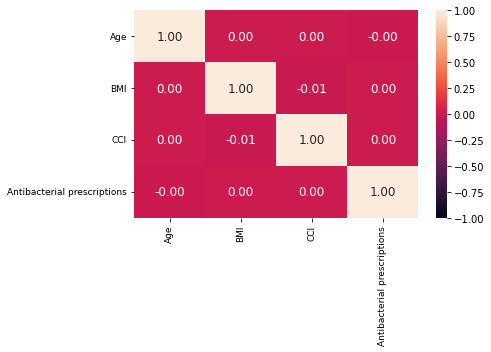

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_lrti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/corr_lrti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [36]:
data_lrti = data_lrti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'lrti_ab_date', 'ab_type_cat', 'incdt_lrti_date', 'date', 'period',
                                   'event_lrti_admitted', 'duration_lrti_admitted'
                                    ]]

In [37]:
#incident and prevalent infection 
data_lrti_incdt = data_lrti[data_lrti['incdt_lrti_date'] == 0]
data_lrti_prevl = data_lrti[data_lrti['incdt_lrti_date'] == 1]
#switch variable lrti_ab_date into a binary variable
data_lrti_incdt[['lrti_ab_date']] = data_lrti_incdt[['lrti_ab_date']].where(data_lrti_incdt[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_lrti_prevl[['lrti_ab_date']] = data_lrti_prevl[['lrti_ab_date']].where(data_lrti_prevl[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_lrti_incdt_males = data_lrti_incdt[data_lrti_incdt['sex'] == 'male']
data_lrti_incdt_females = data_lrti_incdt[data_lrti_incdt['sex'] == 'female']
data_lrti_prevl_males = data_lrti_prevl[data_lrti_prevl['sex'] == 'male']
data_lrti_prevl_females = data_lrti_prevl[data_lrti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_lrti_incdt_15_24 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '15_24']
data_lrti_incdt_25_34 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '25_34']
data_lrti_incdt_35_44 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '35_44']
data_lrti_incdt_45_54 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '45_54']
data_lrti_incdt_55_64 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '55_64']
data_lrti_incdt_65_74 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '65_74']
data_lrti_incdt_75_more = data_lrti_incdt[data_lrti_incdt['age_cat'] == '75_more']
data_lrti_prevl_15_24 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '15_24']
data_lrti_prevl_25_34 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '25_34']
data_lrti_prevl_35_44 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '35_44']
data_lrti_prevl_45_54 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '45_54']
data_lrti_prevl_55_64 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '55_64']
data_lrti_prevl_65_74 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '65_74']
data_lrti_prevl_75_more = data_lrti_prevl[data_lrti_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_lrti_incdt_prepandemic = data_lrti_incdt[data_lrti_incdt['date'] <= '2019-12']
data_lrti_incdt_during_pandemic = data_lrti_incdt[(data_lrti_incdt['date'] >= '2020-03') & (data_lrti_incdt['date']<= '2021-03')]
data_lrti_incdt_post_2nd_lockdown = data_lrti_incdt[data_lrti_incdt['date'] <= '2021-04']
data_lrti_prevl_prepandemic = data_lrti_prevl[data_lrti_prevl['date'] <= '2019-12']
data_lrti_prevl_during_pandemic = data_lrti_prevl[(data_lrti_prevl['date'] >= '2020-03') & (data_lrti_prevl['date']<= '2021-03')]
data_lrti_prevl_post_2nd_lockdown = data_lrti_prevl[data_lrti_prevl['date'] <= '2021-04']

# no antibiotics and incident hospital admission
data_lrti_no_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].isnull()]
data_lrti_no_abs_incdt = data_lrti_no_abs_incdt[data_lrti_no_abs_incdt['incdt_lrti_date'] == 0]

# with antibiotics and incident hospital admission
data_lrti_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_incdt = data_lrti_abs_incdt[data_lrti_abs_incdt['incdt_lrti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_lrti_no_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].isnull()]
data_lrti_no_abs_prevl = data_lrti_no_abs_prevl[data_lrti_no_abs_prevl['incdt_lrti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_lrti_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_prevl = data_lrti_abs_prevl[data_lrti_abs_prevl['incdt_lrti_date'] == 1]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_lrti
# save data
data_lrti.to_csv('../output/hospitalisation_prediction_lrti/data_lrti.csv')

Stored 'data_lrti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident lrti with no antibiotics

<lifelines.CoxPHFitter: fitted with 110865 total observations, 110077 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 110865
number of events observed = 788
   partial log-likelihood = -9133.35
         time fit was run = 2023-03-30 08:29:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.15       1.16       0.11            -0.07             0.36                 0.94                 1.44
CCI_cat[T.medium]                0.18       1.20       0.12            -0.05             0.42                 0.95                 1.52
CCI_cat[T.high]                 -0.09       0.91       0.15            -0.40             0.21                 0.67                 1.23
CCI_cat[T.very_high]             0.20       1.22       0.12            -0.04             0.45                 0.96                 1.56
age_cat[T.25_34]                -0.02       0.98       0.14            -0.29             0.24                 0.75                 1.27
age_cat[T.35_44]                 0.14       1.15       0.13            -0.12             0.39                 0.89                 1.48
age_cat[T.45_54]                -0.03       0.97       0.14            -0.30             0.24                 0.74                 1.27
age_cat[T.55_64]                 0.10       1.10       0.13            -0.16             0.36                 0.85                 1.43
age_cat[T.65_74]                 0.06       1.06       0.13            -0.20             0.32                 0.82                 1.38
age_cat[T.75_more]              -0.13       0.88       0.14            -0.40             0.15                 0.67                 1.16
antibacterial_brit               0.01       1.01       0.03            -0.04             0.06                 0.96                 1.06
bmi_cat[T.obese]                 0.28       1.32       0.15            -0.02             0.58                 0.98                 1.79
bmi_cat[T.overweight]            0.35       1.42       0.18             0.01             0.70                 1.01                 2.01
bmi_cat[T.underweight]           0.11       1.12       0.26            -0.40             0.62                 0.67                 1.86
bmi_cat[T.unknown]               0.37       1.44       0.16             0.05             0.68                 1.06                 1.97
ethnicity[T.unknown]             0.09       1.09       0.12            -0.15             0.32                 0.86                 1.37
ethnicity[T.white]               0.08       1.09       0.11            -0.12             0.29                 0.89                 1.34
flu_vaccine[T.yes]               0.08       1.08       0.12            -0.15             0.31                 0.86                 1.36
imd[T.medium]                   -0.03       0.97       0.12            -0.26             0.20                 0.77                 1.22
imd[T.unaffluent]                0.06       1.06       0.11            -0.16             0.28                 0.85                 1.33
imd[T.unknown]                  -0.31       0.74       0.20            -0.70             0.08                 0.50                 1.09
imd[T.very_affluent]            -0.03       0.97       0.12            -0.25             0.20                 0.78                 1.22
imd[T.very_unaffluent]          -0.04       0.96       0.12            -0.27             0.18                 0.76                 1.20
region[T.east_midlands]         -0.05       0.95       0.15            -0.34             0.24                 0.71                 1.28
region[T.london]                -0.15       0.86       0.13      

12774


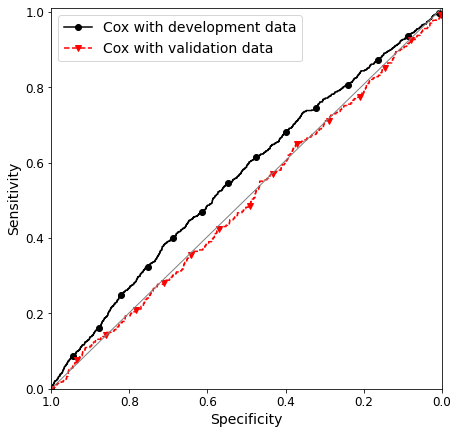

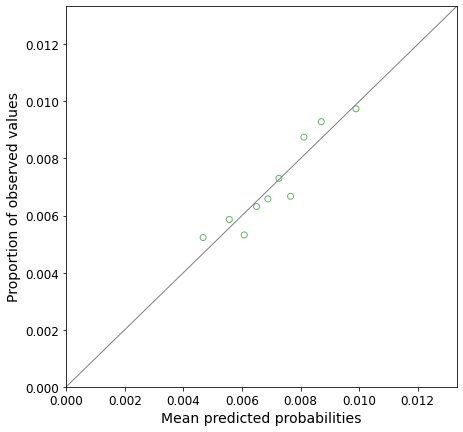

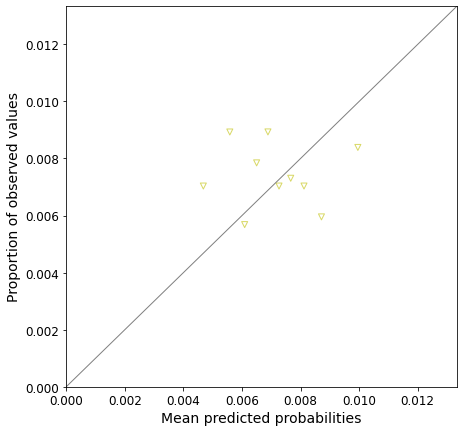

In [39]:
#data prep
data, data_lrti_no_abs_incdt_enc = cox_data_prep(data_lrti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)

try:
    #build cox model 
    cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test = cox_model_build('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_lrti_no_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_incdt.csv', data_lrti_no_abs_incdt_enc, data_lrti_no_abs_incdt, 'sum_betas_cph_lrti_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_lrti_no_abs_incdt, 'event_lrti_admitted', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, 'event_lrti_admitted', data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_incdt_train.jpg', 'calibration_cph_lrti_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_no_abs_incdt, 'lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident lrti with antibiotics

<lifelines.CoxPHFitter: fitted with 12296 total observations, 12208 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 12296
number of events observed = 88
   partial log-likelihood = -808.28
         time fit was run = 2023-03-30 08:30:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.61       0.54       0.29            -1.19            -0.03                 0.31                 0.97
CCI_cat[T.medium]               -0.57       0.57       0.34            -1.23             0.10                 0.29                 1.10
CCI_cat[T.high]                  0.15       1.16       0.33            -0.50             0.80                 0.61                 2.24
CCI_cat[T.very_high]            -0.81       0.44       0.39            -1.57            -0.06                 0.21                 0.95
age_cat[T.25_34]                 0.22       1.25       0.37            -0.50             0.94                 0.60                 2.57
age_cat[T.35_44]                 0.17       1.19       0.37            -0.56             0.90                 0.57                 2.47
age_cat[T.45_54]                -0.18       0.84       0.41            -0.98             0.63                 0.37                 1.87
age_cat[T.55_64]                -0.20       0.82       0.41            -1.01             0.60                 0.36                 1.82
age_cat[T.65_74]                -0.30       0.74       0.42            -1.13             0.52                 0.32                 1.68
age_cat[T.75_more]              -0.28       0.75       0.42            -1.11             0.54                 0.33                 1.72
antibacterial_brit               0.03       1.03       0.07            -0.12             0.17                 0.89                 1.19
bmi_cat[T.obese]                -0.45       0.64       0.35            -1.14             0.24                 0.32                 1.27
bmi_cat[T.overweight]           -0.21       0.81       0.43            -1.06             0.63                 0.35                 1.88
bmi_cat[T.underweight]          -0.86       0.42       0.78            -2.38             0.66                 0.09                 1.93
bmi_cat[T.unknown]              -0.60       0.55       0.39            -1.37             0.17                 0.26                 1.19
ethnicity[T.unknown]            -0.38       0.68       0.34            -1.06             0.29                 0.35                 1.34
ethnicity[T.white]              -0.18       0.84       0.29            -0.74             0.38                 0.48                 1.46
flu_vaccine[T.yes]              -0.03       0.97       0.35            -0.72             0.66                 0.49                 1.93
imd[T.medium]                    0.12       1.13       0.40            -0.66             0.91                 0.52                 2.48
imd[T.unaffluent]                0.69       1.99       0.35            -0.01             1.38                 0.99                 3.98
imd[T.unknown]                   0.62       1.87       0.50            -0.36             1.61                 0.70                 4.99
imd[T.very_affluent]             0.43       1.53       0.37            -0.30             1.16                 0.74                 3.19
imd[T.very_unaffluent]           0.22       1.25       0.39            -0.54             0.98                 0.58                 2.66
region[T.east_midlands]          0.18       1.20       0.49            -0.78             1.13                 0.46                 3.10
region[T.london]                 0.39       1.47       0.41           

12780


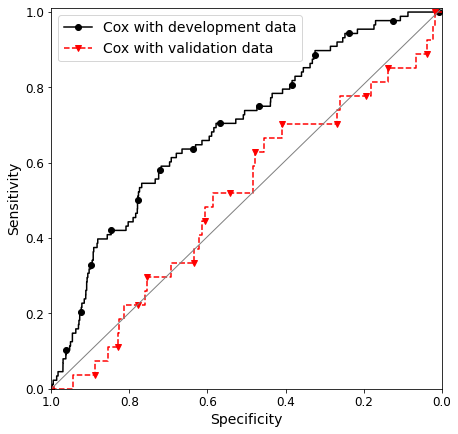

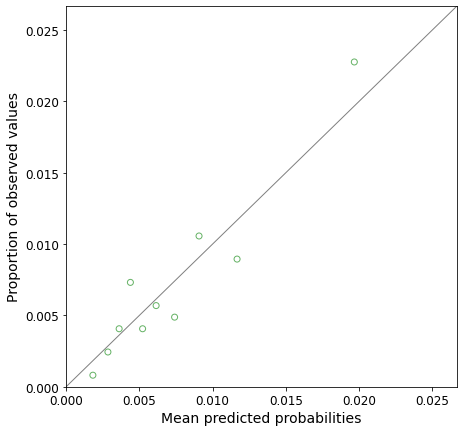

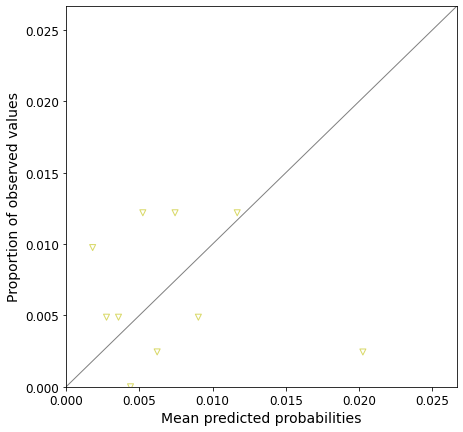

In [40]:
#data prep
data, data_lrti_abs_incdt_enc = cox_data_prep(data_lrti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'abs_incdt', data_lrti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'abs_incdt', data_lrti_abs_incdt)

try:
    #build cox model 
    cph_lrti_abs_incdt, data_lrti_abs_incdt_train, data_lrti_abs_incdt_test = cox_model_build('lrti', 'abs_incdt', data_lrti_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_lrti_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_incdt.csv', data_lrti_abs_incdt_enc, data_lrti_abs_incdt, 'sum_betas_cph_lrti_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_lrti_abs_incdt, 'event_lrti_admitted', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_lrti_abs_incdt, data_lrti_abs_incdt_train, 'event_lrti_admitted', data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_incdt_train.jpg', 'calibration_cph_lrti_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_abs_incdt, 'lrti', 'abs_incdt', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent lrti with no antibiotics

<lifelines.CoxPHFitter: fitted with 12207 total observations, 12118 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 12207
number of events observed = 89
   partial log-likelihood = -818.56
         time fit was run = 2023-03-30 08:30:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.88       0.32            -0.76             0.50                 0.47                 1.65
CCI_cat[T.medium]                0.16       1.17       0.33            -0.49             0.81                 0.61                 2.25
CCI_cat[T.high]                 -0.81       0.45       0.56            -1.91             0.30                 0.15                 1.35
CCI_cat[T.very_high]             0.17       1.18       0.35            -0.51             0.85                 0.60                 2.33
age_cat[T.25_34]                 0.24       1.27       0.47            -0.68             1.15                 0.51                 3.15
age_cat[T.35_44]                 0.64       1.90       0.43            -0.21             1.49                 0.81                 4.44
age_cat[T.45_54]                 0.53       1.70       0.44            -0.34             1.40                 0.71                 4.05
age_cat[T.55_64]                 0.54       1.71       0.44            -0.33             1.41                 0.72                 4.08
age_cat[T.65_74]                 0.62       1.86       0.44            -0.24             1.48                 0.79                 4.40
age_cat[T.75_more]               0.35       1.42       0.47            -0.56             1.26                 0.57                 3.54
antibacterial_brit               0.03       1.03       0.07            -0.11             0.18                 0.89                 1.20
bmi_cat[T.obese]                 0.90       2.46       0.60            -0.27             2.07                 0.77                 7.90
bmi_cat[T.overweight]            0.60       1.82       0.68            -0.73             1.93                 0.48                 6.86
bmi_cat[T.underweight]           0.46       1.58       0.91            -1.33             2.25                 0.26                 9.48
bmi_cat[T.unknown]               1.00       2.73       0.61            -0.19             2.20                 0.83                 9.00
ethnicity[T.unknown]            -0.10       0.90       0.37            -0.84             0.63                 0.43                 1.87
ethnicity[T.white]               0.23       1.26       0.32            -0.39             0.85                 0.68                 2.35
flu_vaccine[T.yes]               0.12       1.12       0.34            -0.54             0.78                 0.58                 2.17
imd[T.medium]                   -0.13       0.88       0.38            -0.88             0.61                 0.42                 1.84
imd[T.unaffluent]                0.20       1.22       0.35            -0.49             0.89                 0.62                 2.43
imd[T.unknown]                  -0.25       0.78       0.63            -1.49             0.99                 0.23                 2.70
imd[T.very_affluent]             0.26       1.29       0.35            -0.42             0.93                 0.66                 2.55
imd[T.very_unaffluent]           0.38       1.47       0.34            -0.28             1.05                 0.76                 2.85
region[T.east_midlands]         -0.28       0.75       0.59            -1.43             0.86                 0.24                 2.37
region[T.london]                 0.11       1.11       0.46           

12759


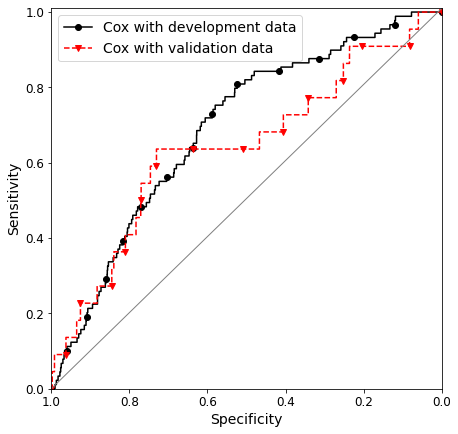

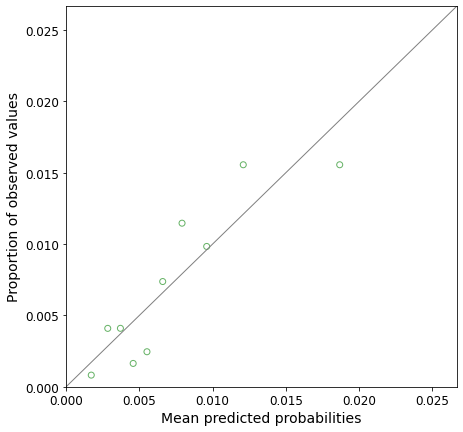

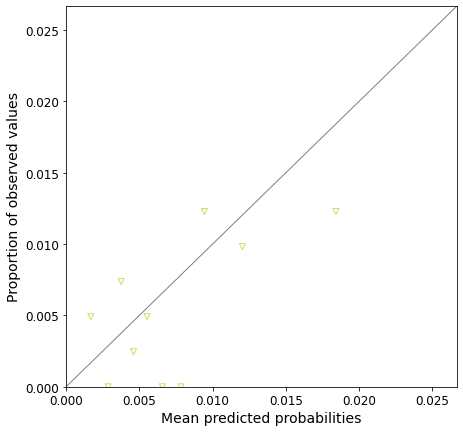

In [41]:
#data prep
data, data_lrti_no_abs_prevl_enc = cox_data_prep(data_lrti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)

try:
    #build cox model 
    cph_lrti_no_abs_prevl, data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test = cox_model_build('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_lrti_no_abs_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_prevl.csv', data_lrti_no_abs_prevl_enc, data_lrti_no_abs_prevl, 'sum_betas_cph_lrti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_lrti_no_abs_prevl, 'event_lrti_admitted', data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_lrti_no_abs_prevl, data_lrti_no_abs_prevl_train, 'event_lrti_admitted', data_lrti_no_abs_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_prevl_train.jpg', 'calibration_cph_lrti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_no_abs_prevl, 'lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent lrti with antibiotics

<lifelines.CoxPHFitter: fitted with 1376 total observations, 1363 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1376
number of events observed = 13
   partial log-likelihood = -80.76
         time fit was run = 2023-03-30 08:30:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.90            -1.88             1.64                 0.15                 5.18
CCI_cat[T.medium]               -0.16       0.85       0.96            -2.03             1.72                 0.13                 5.59
CCI_cat[T.high]                  0.49       1.63       1.06            -1.58             2.56                 0.21                12.93
CCI_cat[T.very_high]            -0.15       0.86       1.03            -2.18             1.87                 0.11                 6.49
age_cat[T.25_34]                 1.23       3.44       1.20            -1.12             3.59                 0.33                36.36
age_cat[T.35_44]                 1.14       3.11       1.18            -1.18             3.45                 0.31                31.53
age_cat[T.45_54]                 0.88       2.41       1.26            -1.60             3.36                 0.20                28.72
age_cat[T.55_64]                 0.69       1.99       1.26            -1.78             3.15                 0.17                23.44
age_cat[T.65_74]                 0.66       1.94       1.26            -1.80             3.12                 0.17                22.75
age_cat[T.75_more]             -17.32       0.00    5747.07        -11281.38         11246.73                 0.00                  inf
antibacterial_brit               0.12       1.12       0.21            -0.29             0.52                 0.75                 1.69
bmi_cat[T.obese]                -0.55       0.58       1.16            -2.82             1.72                 0.06                 5.60
bmi_cat[T.overweight]           -0.62       0.54       1.47            -3.51             2.26                 0.03                 9.58
bmi_cat[T.underweight]         -18.11       0.00   12134.32        -23800.93         23764.71                 0.00                  inf
bmi_cat[T.unknown]               0.71       2.03       1.13            -1.50             2.92                 0.22                18.55
ethnicity[T.unknown]             0.25       1.29       0.93            -1.57             2.08                 0.21                 7.98
ethnicity[T.white]              -0.18       0.84       0.83            -1.80             1.45                 0.17                 4.26
flu_vaccine[T.yes]             -18.03       0.00    6767.88        -13282.83         13246.76                 0.00                  inf
imd[T.medium]                    1.34       3.80       1.15            -0.92             3.59                 0.40                36.19
imd[T.unaffluent]                0.55       1.73       1.26            -1.92             3.01                 0.15                20.29
imd[T.unknown]                 -16.97       0.00   10005.20        -19626.80         19592.85                 0.00                  inf
imd[T.very_affluent]             1.09       2.99       1.17            -1.20             3.39                 0.30                29.61
imd[T.very_unaffluent]           1.08       2.95       1.18            -1.23             3.39                 0.29                29.65
region[T.east_midlands]          0.74       2.09       1.28            -1.77             3.25                 0.17                25.74
region[T.london]                 0.45       1.56       1.20            -1.

12836


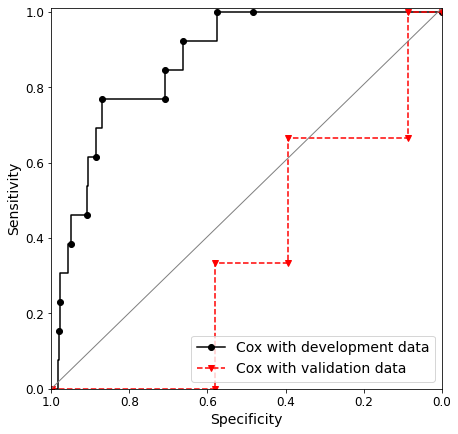

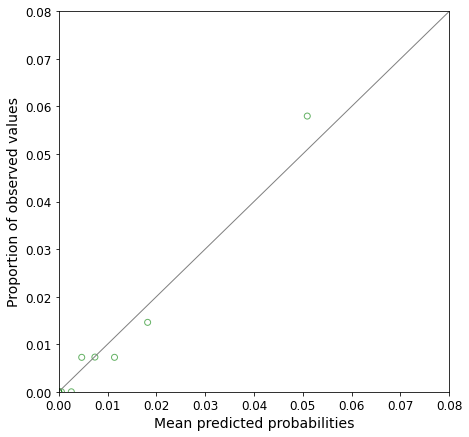

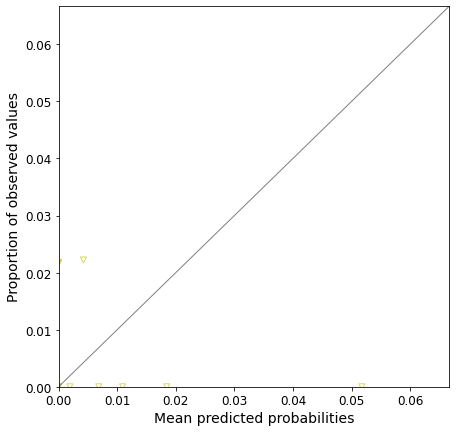

In [42]:
#data prep
data, data_lrti_abs_prevl_enc = cox_data_prep(data_lrti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'abs_prevl', data_lrti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'abs_prevl', data_lrti_abs_prevl)

try:
    #build cox model 
    cph_lrti_abs_prevl, data_lrti_abs_prevl_train, data_lrti_abs_prevl_test = cox_model_build('lrti', 'abs_prevl', data_lrti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_lrti_abs_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_prevl.csv', data_lrti_abs_prevl_enc, data_lrti_abs_prevl, 'sum_betas_cph_lrti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_lrti_abs_prevl, 'event_lrti_admitted', data_lrti_abs_prevl_train, data_lrti_abs_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_lrti_abs_prevl, data_lrti_abs_prevl_train, 'event_lrti_admitted', data_lrti_abs_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_prevl_train.jpg', 'calibration_cph_lrti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_abs_prevl, 'lrti', 'abs_prevl', data_lrti_abs_prevl_train, data_lrti_abs_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident lrti

In [43]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build_2(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test, prob_pred_train, prob_pred_groupby_bin_train, prob_pred_groupby_bin

In [44]:
cph, data_train, data_test, prob_pred_train, prob_pred_groupby_bin_train, prob_pred_groupby_bin = cox_model_abs_build_2('lrti', 'incdt', data_lrti_incdt)

<lifelines.CoxPHFitter: fitted with 123162 total observations, 122279 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 123162
number of events observed = 883
   partial log-likelihood = -10336.74
         time fit was run = 2023-03-30 08:30:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.10            -0.16             0.23                 0.85                 1.26
CCI_cat[T.medium]               -0.01       0.99       0.11            -0.22             0.21                 0.80                 1.24
CCI_cat[T.high]                 -0.11       0.90       0.14            -0.38             0.16                 0.68                 1.18
CCI_cat[T.very_high]             0.03       1.03       0.12            -0.20             0.26                 0.82                 1.29
age_cat[T.25_34]                -0.03       0.97       0.12            -0.27             0.22                 0.76                 1.24
age_cat[T.35_44]                -0.01       0.99       0.12            -0.25             0.23                 0.78                 1.26
age_cat[T.45_54]                -0.05       0.96       0.12            -0.29             0.20                 0.75                 1.22
age_cat[T.55_64]                 0.03       1.03       0.12            -0.21             0.27                 0.81                 1.31
age_cat[T.65_74]                -0.12       0.89       0.13            -0.37             0.13                 0.69                 1.14
age_cat[T.75_more]              -0.16       0.85       0.13            -0.41             0.09                 0.66                 1.10
antibacterial_brit               0.00       1.00       0.02            -0.05             0.05                 0.96                 1.05
bmi_cat[T.obese]                 0.06       1.06       0.13            -0.20             0.32                 0.82                 1.37
bmi_cat[T.overweight]            0.14       1.15       0.16            -0.17             0.45                 0.85                 1.56
bmi_cat[T.underweight]          -0.16       0.85       0.24            -0.64             0.31                 0.53                 1.36
bmi_cat[T.unknown]               0.09       1.10       0.14            -0.18             0.37                 0.84                 1.44
ethnicity[T.unknown]             0.04       1.04       0.11            -0.18             0.25                 0.83                 1.29
ethnicity[T.white]               0.07       1.07       0.10            -0.12             0.26                 0.88                 1.30
flu_vaccine[T.yes]               0.07       1.08       0.11            -0.14             0.29                 0.87                 1.33
imd[T.medium]                   -0.06       0.94       0.11            -0.28             0.15                 0.76                 1.16
imd[T.unaffluent]                0.02       1.02       0.11            -0.19             0.22                 0.82                 1.25
imd[T.unknown]                  -0.16       0.85       0.18            -0.50             0.18                 0.60                 1.20
imd[T.very_affluent]            -0.09       0.91       0.11            -0.30             0.13                 0.74                 1.13
imd[T.very_unaffluent]          -0.06       0.94       0.11            -0.27             0.15                 0.76                 1.17
lrti_ab_date                     0.02       1.02       0.11            -0.19             0.24                 0.82                 1.27
region[T.east_midlands]          0.02       1.02       0.14     

13049


In [45]:
prob_pred_train

,pred,bins,lrti_ab_date
182555,0.005582,"(0.00225, 0.00583]",0
185638,0.007123,"(0.00689, 0.00716]",0
157469,0.007807,"(0.00774, 0.0081]",0
173892,0.007816,"(0.00774, 0.0081]",0
155927,0.006573,"(0.00627, 0.0066]",0
...,...,...,...
263018,0.006448,"(0.00627, 0.0066]",0
227787,0.006870,"(0.0066, 0.00689]",0
289224,0.006672,"(0.0066, 0.00689]",0
322116,0.005841,"(0.00583, 0.00627]",0


In [46]:
prob_pred_groupby_bin_train

,bins,pred_mean_train,pred_sum,pred_count,ab_prob_mean_train,ab_prob_sum,ab_prob_count
0,"(0.00225, 0.00583]",0.005388,66.365420,12317,0.078185,963,12317
1,"(0.00583, 0.00627]",0.006063,74.672426,12316,0.081195,1000,12316
2,"(0.00627, 0.0066]",0.006438,79.293683,12316,0.089964,1108,12316
3,"(0.0066, 0.00689]",0.006742,83.046492,12317,0.093610,1153,12317
4,"(0.00689, 0.00716]",0.007024,86.520760,12317,0.098157,1209,12317
5,"(0.00716, 0.00744]",0.007300,89.897751,12314,0.098587,1214,12314
6,"(0.00744, 0.00774]",0.007587,93.438154,12316,0.107421,1323,12316
7,"(0.00774, 0.0081]",0.007912,97.444069,12316,0.106690,1314,12316
8,"(0.0081, 0.0086]",0.008330,102.587960,12316,0.114323,1408,12316
9,"(0.0086, 0.0118]",0.009165,112.886680,12317,0.129009,1589,12317


In [47]:
prob_pred_groupby_bin

,pred_mean_train,ab_prob_mean_train,pred_mean_test,ab_prob_mean_test
0,0.005388,0.078185,0.005382,0.083536
1,0.006063,0.081195,0.006064,0.083069
2,0.006438,0.089964,0.006437,0.090865
3,0.006742,0.093610,0.006750,0.095714
4,0.007024,0.098157,0.007030,0.091596
5,0.007300,0.098587,0.007301,0.100853
6,0.007587,0.107421,0.007588,0.109596
7,0.007912,0.106690,0.007909,0.103776
8,0.008330,0.114323,0.008325,0.113764
9,0.009165,0.129009,0.009159,0.129323


In [48]:
#data prep
data, data_lrti_incdt_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'incdt', data_lrti_incdt_enc)
make_summary_table_hosped('lrti', 'incdt', data_lrti_incdt)

try:
    cph_lrti_incdt, data_lrti_incdt_train, data_lrti_incdt_test = cox_model_abs_build('lrti', 'incdt', data_lrti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt, 'lrti', 'incdt', data_lrti_incdt_train, data_lrti_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 123162 total observations, 122279 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 123162
number of events observed = 883
   partial log-likelihood = -10336.74
         time fit was run = 2023-03-30 08:30:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.10            -0.16             0.23                 0.85                 1.26
CCI_cat[T.medium]               -0.01       0.99       0.11            -0.22             0.21                 0.80                 1.24
CCI_cat[T.high]                 -0.11       0.90       0.14            -0.38             0.16                 0.68                 1.18
CCI_cat[T.very_high]             0.03       1.03       0.12            -0.20             0.26                 0.82                 1.29
age_cat[T.25_34]                -0.03       0.97       0.12            -0.27             0.22                 0.76                 1.24
age_cat[T.35_44]                -0.01       0.99       0.12            -0.25             0.23                 0.78                 1.26
age_cat[T.45_54]                -0.05       0.96       0.12            -0.29             0.20                 0.75                 1.22
age_cat[T.55_64]                 0.03       1.03       0.12            -0.21             0.27                 0.81                 1.31
age_cat[T.65_74]                -0.12       0.89       0.13            -0.37             0.13                 0.69                 1.14
age_cat[T.75_more]              -0.16       0.85       0.13            -0.41             0.09                 0.66                 1.10
antibacterial_brit               0.00       1.00       0.02            -0.05             0.05                 0.96                 1.05
bmi_cat[T.obese]                 0.06       1.06       0.13            -0.20             0.32                 0.82                 1.37
bmi_cat[T.overweight]            0.14       1.15       0.16            -0.17             0.45                 0.85                 1.56
bmi_cat[T.underweight]          -0.16       0.85       0.24            -0.64             0.31                 0.53                 1.36
bmi_cat[T.unknown]               0.09       1.10       0.14            -0.18             0.37                 0.84                 1.44
ethnicity[T.unknown]             0.04       1.04       0.11            -0.18             0.25                 0.83                 1.29
ethnicity[T.white]               0.07       1.07       0.10            -0.12             0.26                 0.88                 1.30
flu_vaccine[T.yes]               0.07       1.08       0.11            -0.14             0.29                 0.87                 1.33
imd[T.medium]                   -0.06       0.94       0.11            -0.28             0.15                 0.76                 1.16
imd[T.unaffluent]                0.02       1.02       0.11            -0.19             0.22                 0.82                 1.25
imd[T.unknown]                  -0.16       0.85       0.18            -0.50             0.18                 0.60                 1.20
imd[T.very_affluent]            -0.09       0.91       0.11            -0.30             0.13                 0.74                 1.13
imd[T.very_unaffluent]          -0.06       0.94       0.11            -0.27             0.15                 0.76                 1.17
lrti_ab_date                     0.02       1.02       0.11            -0.19             0.24                 0.82                 1.27
region[T.east_midlands]          0.02       1.02       0.14     

13049


### 5-6- hospital admission related to prevalent lrti

In [49]:
#data prep
data, data_lrti_prevl_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'prevl', data_lrti_prevl_enc)
make_summary_table_hosped('lrti', 'prevl', data_lrti_prevl)

try:
    cph_lrti_prevl, data_lrti_prevl_train, data_lrti_prevl_test = cox_model_abs_build('lrti', 'prevl', data_lrti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl, 'lrti', 'prevl', data_lrti_prevl_train, data_lrti_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13584 total observations, 13481 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 13584
number of events observed = 103
   partial log-likelihood = -950.49
         time fit was run = 2023-03-30 08:30:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.31            -0.66             0.55                 0.52                 1.73
CCI_cat[T.medium]                0.24       1.27       0.32            -0.38             0.85                 0.68                 2.35
CCI_cat[T.high]                 -0.10       0.91       0.42            -0.92             0.72                 0.40                 2.05
CCI_cat[T.very_high]             0.15       1.17       0.34            -0.51             0.82                 0.60                 2.27
age_cat[T.25_34]                 0.53       1.70       0.44            -0.34             1.40                 0.71                 4.05
age_cat[T.35_44]                 0.94       2.57       0.42             0.13             1.76                 1.14                 5.81
age_cat[T.45_54]                 0.73       2.08       0.43            -0.11             1.57                 0.90                 4.82
age_cat[T.55_64]                 0.65       1.91       0.43            -0.20             1.50                 0.82                 4.48
age_cat[T.65_74]                 0.76       2.13       0.43            -0.08             1.60                 0.92                 4.95
age_cat[T.75_more]               0.27       1.30       0.47            -0.67             1.20                 0.51                 3.31
antibacterial_brit               0.01       1.01       0.07            -0.12             0.15                 0.88                 1.16
bmi_cat[T.obese]                 1.44       4.24       0.72             0.03             2.86                 1.03                17.38
bmi_cat[T.overweight]            0.84       2.31       0.80            -0.73             2.41                 0.48                11.14
bmi_cat[T.underweight]           0.79       2.20       1.00            -1.18             2.75                 0.31                15.61
bmi_cat[T.unknown]               1.69       5.40       0.73             0.26             3.11                 1.30                22.47
ethnicity[T.unknown]            -0.28       0.75       0.32            -0.92             0.35                 0.40                 1.42
ethnicity[T.white]              -0.06       0.94       0.27            -0.60             0.47                 0.55                 1.60
flu_vaccine[T.yes]              -0.04       0.96       0.33            -0.69             0.62                 0.50                 1.85
imd[T.medium]                    0.05       1.06       0.36            -0.65             0.76                 0.52                 2.14
imd[T.unaffluent]                0.16       1.17       0.35            -0.54             0.85                 0.58                 2.35
imd[T.unknown]                  -1.40       0.25       1.03            -3.42             0.63                 0.03                 1.87
imd[T.very_affluent]             0.58       1.79       0.33            -0.06             1.22                 0.94                 3.39
imd[T.very_unaffluent]           0.67       1.96       0.32             0.05             1.30                 1.05                 3.66
lrti_ab_date                     0.35       1.41       0.29            -0.22             0.91                 0.80                 2.49
region[T.east_midlands]         -0.14       0.87       0.52          

13024


### 5-7- hospital admission related to incident lrti with prescribed antibiotics categories

In [50]:
#data prep
data, data_lrti_incdt_abs_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_abs, data_lrti_incdt_abs_train, data_lrti_incdt_abs_test = cox_model_ab_type_build('lrti', 'incdt_ab_type', data_lrti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_abs, 'lrti', 'incdt_abs', data_lrti_incdt_abs_train, data_lrti_incdt_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 123162 total observations, 122279 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 123162
number of events observed = 883
   partial log-likelihood = -10334.79
         time fit was run = 2023-03-30 08:30:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.10            -0.16             0.23                 0.85                 1.26
CCI_cat[T.medium]               -0.01       0.99       0.11            -0.22             0.21                 0.80                 1.24
CCI_cat[T.high]                 -0.11       0.90       0.14            -0.38             0.16                 0.68                 1.18
CCI_cat[T.very_high]             0.03       1.03       0.12            -0.19             0.26                 0.82                 1.29
ab_type_cat[T.Doxycycline]     -12.48       0.00     446.63          -887.86           862.90                 0.00                  inf
ab_type_cat[T.no]                0.25       1.28       0.50            -0.73             1.23                 0.48                 3.43
ab_type_cat[T.other]             0.31       1.36       0.51            -0.69             1.31                 0.50                 3.71
age_cat[T.25_34]                -0.03       0.97       0.12            -0.27             0.22                 0.76                 1.24
age_cat[T.35_44]                -0.01       0.99       0.12            -0.25             0.23                 0.78                 1.26
age_cat[T.45_54]                -0.05       0.96       0.12            -0.29             0.20                 0.75                 1.22
age_cat[T.55_64]                 0.03       1.03       0.12            -0.21             0.27                 0.81                 1.31
age_cat[T.65_74]                -0.12       0.89       0.13            -0.37             0.13                 0.69                 1.14
age_cat[T.75_more]              -0.16       0.85       0.13            -0.41             0.09                 0.66                 1.10
antibacterial_brit               0.00       1.00       0.02            -0.05             0.05                 0.96                 1.05
bmi_cat[T.obese]                 0.06       1.06       0.13            -0.20             0.32                 0.82                 1.37
bmi_cat[T.overweight]            0.14       1.15       0.16            -0.17             0.45                 0.85                 1.56
bmi_cat[T.underweight]          -0.16       0.85       0.24            -0.64             0.31                 0.53                 1.37
bmi_cat[T.unknown]               0.09       1.10       0.14            -0.18             0.37                 0.84                 1.44
ethnicity[T.unknown]             0.04       1.04       0.11            -0.18             0.25                 0.83                 1.29
ethnicity[T.white]               0.07       1.07       0.10            -0.13             0.26                 0.88                 1.30
flu_vaccine[T.yes]               0.07       1.07       0.11            -0.14             0.29                 0.87                 1.33
imd[T.medium]                   -0.06       0.94       0.11            -0.28             0.15                 0.76                 1.16
imd[T.unaffluent]                0.02       1.02       0.11            -0.19             0.22                 0.82                 1.25
imd[T.unknown]                  -0.16       0.85       0.18            -0.50             0.18                 0.60                 1.20
imd[T.very_affluent]            -0.09       0.91       0.11     

13620


### 5-8- hospital admission related to prevalent lrti with prescribed antibiotics categories

In [51]:
#data prep
data, data_lrti_prevl_abs_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_abs, data_lrti_prevl_abs_train, data_lrti_prevl_abs_test = cox_model_ab_type_build('lrti', 'prevl_ab_type', data_lrti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_abs, 'lrti', 'prevl_abs', data_lrti_prevl_abs_train, data_lrti_prevl_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13584 total observations, 13481 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 13584
number of events observed = 103
   partial log-likelihood = -949.15
         time fit was run = 2023-03-30 08:30:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.31            -0.65             0.55                 0.52                 1.73
CCI_cat[T.medium]                0.23       1.25       0.32            -0.39             0.85                 0.67                 2.33
CCI_cat[T.high]                 -0.10       0.91       0.42            -0.91             0.72                 0.40                 2.06
CCI_cat[T.very_high]             0.15       1.16       0.34            -0.52             0.81                 0.60                 2.26
ab_type_cat[T.Doxycycline]       0.04       1.05       1.23            -2.37             2.46                 0.09                11.76
ab_type_cat[T.no]               -1.38       0.25       0.72            -2.79             0.03                 0.06                 1.03
ab_type_cat[T.other]            -1.20       0.30       0.77            -2.71             0.32                 0.07                 1.37
age_cat[T.25_34]                 0.53       1.70       0.44            -0.34             1.40                 0.71                 4.07
age_cat[T.35_44]                 0.95       2.57       0.42             0.13             1.76                 1.14                 5.82
age_cat[T.45_54]                 0.73       2.07       0.43            -0.12             1.57                 0.89                 4.80
age_cat[T.55_64]                 0.66       1.93       0.43            -0.19             1.50                 0.82                 4.50
age_cat[T.65_74]                 0.76       2.14       0.43            -0.08             1.60                 0.92                 4.98
age_cat[T.75_more]               0.27       1.31       0.47            -0.66             1.20                 0.52                 3.33
antibacterial_brit               0.01       1.01       0.07            -0.13             0.14                 0.88                 1.16
bmi_cat[T.obese]                 1.45       4.25       0.72             0.04             2.86                 1.04                17.43
bmi_cat[T.overweight]            0.85       2.35       0.80            -0.72             2.43                 0.49                11.31
bmi_cat[T.underweight]           0.77       2.16       1.00            -1.19             2.73                 0.30                15.36
bmi_cat[T.unknown]               1.69       5.45       0.73             0.27             3.12                 1.31                22.67
ethnicity[T.unknown]            -0.28       0.75       0.32            -0.92             0.35                 0.40                 1.42
ethnicity[T.white]              -0.07       0.94       0.27            -0.60             0.47                 0.55                 1.60
flu_vaccine[T.yes]              -0.04       0.96       0.33            -0.69             0.62                 0.50                 1.86
imd[T.medium]                    0.06       1.06       0.36            -0.65             0.77                 0.52                 2.15
imd[T.unaffluent]                0.17       1.18       0.35            -0.53             0.86                 0.59                 2.37
imd[T.unknown]                  -1.40       0.25       1.03            -3.43             0.62                 0.03                 1.87
imd[T.very_affluent]             0.59       1.80       0.33          

13592


### 5-9- stratified by sex
#### 5-9-1- incident males

In [52]:
#data prep
data, data_lrti_incdt_males_enc = cox_data_prep(data_lrti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_males, data_lrti_incdt_males_train, data_lrti_incdt_males_test = cox_model_strat_sex_build('lrti', 'incdt_males', data_lrti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_males, 'lrti', 'incdt_males', data_lrti_incdt_males_train, data_lrti_incdt_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 59711 total observations, 59265 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 59711
number of events observed = 446
   partial log-likelihood = -4889.46
         time fit was run = 2023-03-30 08:30:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.14            -0.27             0.29                 0.76                 1.33
CCI_cat[T.medium]                0.10       1.10       0.16            -0.21             0.40                 0.81                 1.49
CCI_cat[T.high]                 -0.09       0.91       0.20            -0.48             0.29                 0.62                 1.34
CCI_cat[T.very_high]             0.10       1.10       0.16            -0.22             0.41                 0.80                 1.51
age_cat[T.25_34]                 0.15       1.16       0.18            -0.20             0.50                 0.82                 1.65
age_cat[T.35_44]                 0.16       1.18       0.18            -0.19             0.51                 0.83                 1.67
age_cat[T.45_54]                 0.27       1.31       0.18            -0.08             0.61                 0.93                 1.84
age_cat[T.55_64]                 0.09       1.09       0.18            -0.27             0.44                 0.77                 1.56
age_cat[T.65_74]                 0.06       1.06       0.18            -0.31             0.42                 0.74                 1.52
age_cat[T.75_more]              -0.06       0.94       0.19            -0.43             0.31                 0.65                 1.36
antibacterial_brit              -0.03       0.97       0.03            -0.09             0.04                 0.91                 1.04
bmi_cat[T.obese]                -0.30       0.74       0.16            -0.63             0.02                 0.53                 1.02
bmi_cat[T.overweight]           -0.18       0.84       0.20            -0.57             0.22                 0.56                 1.24
bmi_cat[T.underweight]          -0.75       0.47       0.37            -1.47            -0.04                 0.23                 0.96
bmi_cat[T.unknown]              -0.14       0.87       0.17            -0.48             0.20                 0.62                 1.22
ethnicity[T.unknown]            -0.14       0.87       0.16            -0.44             0.17                 0.64                 1.18
ethnicity[T.white]               0.01       1.01       0.13            -0.25             0.28                 0.78                 1.32
flu_vaccine[T.yes]               0.11       1.12       0.15            -0.19             0.41                 0.83                 1.51
imd[T.medium]                   -0.21       0.81       0.15            -0.51             0.09                 0.60                 1.10
imd[T.unaffluent]               -0.09       0.91       0.15            -0.38             0.20                 0.68                 1.22
imd[T.unknown]                  -0.05       0.95       0.23            -0.50             0.39                 0.61                 1.48
imd[T.very_affluent]            -0.17       0.84       0.15            -0.47             0.13                 0.62                 1.14
imd[T.very_unaffluent]          -0.15       0.86       0.15            -0.45             0.14                 0.64                 1.15
lrti_ab_date                    -0.01       0.99       0.16            -0.32             0.30                 0.72                 1.35
region[T.east_midlands]          0.25       1.28       0.21         

12779


#### 5-9-2- incident females

In [53]:
#data prep
data, data_lrti_incdt_females_enc = cox_data_prep(data_lrti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_females, data_lrti_incdt_females_train, data_lrti_incdt_females_test = cox_model_strat_sex_build('lrti', 'incdt_females', data_lrti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_females, 'lrti', 'incdt_females', data_lrti_incdt_females_train, data_lrti_incdt_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 63450 total observations, 62996 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 63450
number of events observed = 454
   partial log-likelihood = -4995.71
         time fit was run = 2023-03-30 08:30:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.13       1.13       0.14            -0.16             0.41                 0.86                 1.50
CCI_cat[T.medium]                0.09       1.09       0.16            -0.22             0.40                 0.80                 1.49
CCI_cat[T.high]                  0.07       1.08       0.19            -0.30             0.45                 0.74                 1.56
CCI_cat[T.very_high]             0.07       1.07       0.17            -0.25             0.40                 0.78                 1.49
age_cat[T.25_34]                 0.09       1.09       0.16            -0.24             0.41                 0.79                 1.50
age_cat[T.35_44]                -0.04       0.96       0.17            -0.38             0.29                 0.68                 1.34
age_cat[T.45_54]                -0.37       0.69       0.19            -0.73            -0.00                 0.48                 1.00
age_cat[T.55_64]                 0.15       1.16       0.16            -0.17             0.47                 0.84                 1.59
age_cat[T.65_74]                -0.30       0.74       0.18            -0.66             0.06                 0.52                 1.06
age_cat[T.75_more]              -0.19       0.83       0.18            -0.54             0.16                 0.58                 1.18
antibacterial_brit               0.04       1.04       0.03            -0.03             0.10                 0.97                 1.11
bmi_cat[T.obese]                 0.39       1.48       0.21            -0.02             0.80                 0.98                 2.24
bmi_cat[T.overweight]            0.39       1.48       0.24            -0.08             0.87                 0.92                 2.39
bmi_cat[T.underweight]           0.19       1.20       0.35            -0.50             0.87                 0.60                 2.40
bmi_cat[T.unknown]               0.46       1.58       0.22             0.03             0.89                 1.03                 2.43
ethnicity[T.unknown]             0.02       1.02       0.16            -0.28             0.33                 0.75                 1.39
ethnicity[T.white]               0.09       1.09       0.14            -0.18             0.36                 0.83                 1.44
flu_vaccine[T.yes]               0.12       1.13       0.15            -0.17             0.41                 0.84                 1.51
imd[T.medium]                   -0.06       0.94       0.15            -0.36             0.24                 0.70                 1.27
imd[T.unaffluent]                0.11       1.12       0.15            -0.17             0.40                 0.84                 1.49
imd[T.unknown]                  -0.48       0.62       0.28            -1.02             0.07                 0.36                 1.07
imd[T.very_affluent]             0.07       1.07       0.15            -0.22             0.36                 0.80                 1.43
imd[T.very_unaffluent]          -0.14       0.87       0.16            -0.44             0.17                 0.64                 1.18
lrti_ab_date                    -0.04       0.96       0.16            -0.35             0.27                 0.70                 1.31
region[T.east_midlands]         -0.23       0.80       0.19         

12774


#### 5-9-3- prevalent males

In [54]:
#data prep
data, data_lrti_prevl_males_enc = cox_data_prep(data_lrti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_males, data_lrti_prevl_males_train, data_lrti_prevl_males_test = cox_model_strat_sex_build('lrti', 'prevl_males', data_lrti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_lrti_prevl_males, 'lrti', 'prevl_males', data_lrti_prevl_males_train, data_lrti_prevl_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6593 total observations, 6549 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 6593
number of events observed = 44
   partial log-likelihood = -362.33
         time fit was run = 2023-03-30 08:30:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.26       1.29       0.48            -0.68             1.19                 0.51                 3.29
CCI_cat[T.medium]                0.57       1.77       0.49            -0.39             1.53                 0.67                 4.62
CCI_cat[T.high]                 -0.14       0.87       0.71            -1.53             1.25                 0.22                 3.48
CCI_cat[T.very_high]            -0.47       0.63       0.65            -1.74             0.80                 0.18                 2.23
age_cat[T.25_34]                -0.17       0.84       0.67            -1.49             1.15                 0.23                 3.15
age_cat[T.35_44]                 0.52       1.69       0.57            -0.60             1.65                 0.55                 5.19
age_cat[T.45_54]                 0.61       1.84       0.56            -0.49             1.71                 0.61                 5.53
age_cat[T.55_64]                -0.55       0.58       0.73            -1.98             0.89                 0.14                 2.43
age_cat[T.65_74]                 0.83       2.29       0.54            -0.23             1.89                 0.79                 6.60
age_cat[T.75_more]              -0.17       0.84       0.67            -1.49             1.14                 0.22                 3.14
antibacterial_brit               0.08       1.09       0.11            -0.12             0.29                 0.89                 1.34
bmi_cat[T.obese]                 0.52       1.68       0.74            -0.93             1.97                 0.40                 7.15
bmi_cat[T.overweight]            0.38       1.46       0.87            -1.33             2.08                 0.27                 7.99
bmi_cat[T.underweight]         -15.26       0.00    2228.72         -4383.47          4352.96                 0.00                  inf
bmi_cat[T.unknown]               0.77       2.17       0.76            -0.71             2.26                 0.49                 9.57
ethnicity[T.unknown]            -0.42       0.66       0.56            -1.52             0.68                 0.22                 1.97
ethnicity[T.white]               0.27       1.31       0.45            -0.61             1.15                 0.55                 3.16
flu_vaccine[T.yes]              -0.80       0.45       0.73            -2.23             0.62                 0.11                 1.86
imd[T.medium]                   -0.06       0.94       0.58            -1.20             1.07                 0.30                 2.92
imd[T.unaffluent]                0.23       1.26       0.54            -0.83             1.30                 0.44                 3.66
imd[T.unknown]                   0.41       1.50       0.82            -1.20             2.01                 0.30                 7.49
imd[T.very_affluent]             0.30       1.35       0.54            -0.76             1.36                 0.47                 3.89
imd[T.very_unaffluent]           0.83       2.30       0.49            -0.13             1.79                 0.88                 6.00
lrti_ab_date                     0.40       1.50       0.44            -0.47             1.27                 0.63                 3.58
region[T.east_midlands]          1.00       2.71       0.84            -0

12768


#### 5-9-4- prevalent females

In [55]:
try:
    #data prep
    data, data_lrti_prevl_females_enc = cox_data_prep(data_lrti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

    #cox model
    cph_lrti_prevl_females, data_lrti_prevl_females_train, data_lrti_prevl_females_test = cox_model_strat_sex_build('lrti', 'prevl_females', data_lrti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_females, 'lrti', 'prevl_females', data_lrti_prevl_females_train, data_lrti_prevl_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6990 total observations, 6939 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 6990
number of events observed = 51
   partial log-likelihood = -432.98
         time fit was run = 2023-03-30 08:30:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.34       0.71       0.46            -1.24             0.56                 0.29                 1.75
CCI_cat[T.medium]                0.04       1.04       0.47            -0.88             0.95                 0.42                 2.59
CCI_cat[T.high]                 -0.05       0.95       0.57            -1.17             1.07                 0.31                 2.92
CCI_cat[T.very_high]             0.50       1.65       0.44            -0.36             1.37                 0.70                 3.92
age_cat[T.25_34]                 0.50       1.64       0.73            -0.94             1.93                 0.39                 6.89
age_cat[T.35_44]                 1.38       3.96       0.65             0.11             2.64                 1.11                14.08
age_cat[T.45_54]                 0.87       2.39       0.69            -0.48             2.23                 0.62                 9.27
age_cat[T.55_64]                 1.07       2.93       0.67            -0.24             2.38                 0.79                10.84
age_cat[T.65_74]                 0.97       2.63       0.68            -0.36             2.30                 0.69                 9.93
age_cat[T.75_more]               0.83       2.29       0.69            -0.53             2.18                 0.59                 8.86
antibacterial_brit               0.03       1.03       0.10            -0.17             0.22                 0.85                 1.25
bmi_cat[T.obese]                 0.65       1.91       0.73            -0.79             2.08                 0.45                 8.03
bmi_cat[T.overweight]           -0.14       0.87       0.92            -1.94             1.65                 0.14                 5.23
bmi_cat[T.underweight]           1.06       2.90       0.92            -0.73             2.86                 0.48                17.46
bmi_cat[T.unknown]               0.52       1.68       0.76            -0.98             2.01                 0.38                 7.49
ethnicity[T.unknown]             0.16       1.18       0.44            -0.70             1.03                 0.50                 2.79
ethnicity[T.white]              -0.15       0.86       0.40            -0.94             0.64                 0.39                 1.89
flu_vaccine[T.yes]               0.53       1.71       0.39            -0.22             1.29                 0.80                 3.64
imd[T.medium]                    0.07       1.07       0.50            -0.92             1.06                 0.40                 2.87
imd[T.unaffluent]                0.27       1.31       0.48            -0.67             1.20                 0.51                 3.32
imd[T.unknown]                 -16.59       0.00    2862.04         -5626.08          5592.91                 0.00                  inf
imd[T.very_affluent]             0.53       1.71       0.45            -0.35             1.42                 0.70                 4.14
imd[T.very_unaffluent]           0.46       1.59       0.46            -0.44             1.36                 0.64                 3.90
lrti_ab_date                     0.42       1.52       0.41            -0.38             1.22                 0.68                 3.39
region[T.east_midlands]         -0.46       0.63       0.73            -1

12766


### 5-10- stratified by age category
#### 5-10-1- incident

In [56]:
#data prep
data, data_lrti_incdt_15_24_enc = cox_data_prep(data_lrti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_15_24, data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test = cox_model_strat_age_build('lrti', 'incdt_15_24', data_lrti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_15_24, 'lrti', 'incdt_15_24', data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17579 total observations, 17458 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17579
number of events observed = 121
   partial log-likelihood = -1171.45
         time fit was run = 2023-03-30 08:30:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.28       0.76       0.25            -0.77             0.21                 0.46                 1.24
CCI_cat[T.medium]               -0.34       0.71       0.29            -0.90             0.23                 0.41                 1.25
CCI_cat[T.high]                 -0.31       0.74       0.35            -0.99             0.38                 0.37                 1.46
CCI_cat[T.very_high]            -0.44       0.65       0.31            -1.04             0.17                 0.35                 1.18
antibacterial_brit               0.06       1.06       0.06            -0.06             0.18                 0.94                 1.20
bmi_cat[T.obese]                 0.75       2.11       0.46            -0.16             1.66                 0.85                 5.24
bmi_cat[T.overweight]            0.86       2.36       0.51            -0.15             1.86                 0.86                 6.45
bmi_cat[T.underweight]           0.76       2.15       0.67            -0.55             2.08                 0.58                 8.01
bmi_cat[T.unknown]               0.75       2.13       0.48            -0.19             1.70                 0.83                 5.48
ethnicity[T.unknown]             0.07       1.07       0.28            -0.48             0.62                 0.62                 1.86
ethnicity[T.white]              -0.20       0.82       0.26            -0.70             0.30                 0.50                 1.35
flu_vaccine[T.yes]               0.13       1.14       0.29            -0.44             0.71                 0.64                 2.04
imd[T.medium]                   -0.02       0.98       0.29            -0.59             0.55                 0.56                 1.73
imd[T.unaffluent]               -0.29       0.75       0.30            -0.88             0.31                 0.41                 1.37
imd[T.unknown]                   0.01       1.01       0.43            -0.83             0.85                 0.44                 2.34
imd[T.very_affluent]            -0.12       0.89       0.29            -0.69             0.46                 0.50                 1.58
imd[T.very_unaffluent]          -0.01       0.99       0.28            -0.57             0.54                 0.57                 1.72
lrti_ab_date                     0.14       1.15       0.29            -0.44             0.71                 0.65                 2.04
region[T.east_midlands]         -0.74       0.48       0.46            -1.64             0.16                 0.19                 1.17
region[T.london]                 0.06       1.06       0.31            -0.55             0.67                 0.58                 1.96
region[T.north_east]            -0.39       0.68       0.41            -1.19             0.41                 0.30                 1.51
region[T.north_west]            -0.46       0.63       0.42            -1.28             0.37                 0.28                 1.45
region[T.south_east]            -0.10       0.90       0.38            -0.85             0.64                 0.43                 1.90
region[T.south_west]            -0.25       0.78       0.39            -1.01             0.51                 0.36                 1.67
region[T.west_midlands]         -0.18       0.84       0.38         

11408


In [57]:
#data prep
data, data_lrti_incdt_25_34_enc = cox_data_prep(data_lrti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_25_34, data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test = cox_model_strat_age_build('lrti', 'incdt_25_34', data_lrti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_25_34, 'lrti', 'incdt_25_34', data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17788 total observations, 17663 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17788
number of events observed = 125
   partial log-likelihood = -1199.04
         time fit was run = 2023-03-30 08:30:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.37       0.69       0.23            -0.82             0.09                 0.44                 1.10
CCI_cat[T.medium]               -1.03       0.36       0.32            -1.66            -0.40                 0.19                 0.67
CCI_cat[T.high]                 -0.76       0.47       0.38            -1.50            -0.02                 0.22                 0.98
CCI_cat[T.very_high]            -0.17       0.84       0.27            -0.70             0.35                 0.50                 1.42
antibacterial_brit               0.00       1.00       0.06            -0.12             0.12                 0.88                 1.13
bmi_cat[T.obese]                -0.39       0.68       0.31            -1.00             0.21                 0.37                 1.23
bmi_cat[T.overweight]            0.11       1.12       0.35            -0.58             0.81                 0.56                 2.24
bmi_cat[T.underweight]          -0.10       0.91       0.53            -1.13             0.94                 0.32                 2.55
bmi_cat[T.unknown]              -0.44       0.64       0.34            -1.10             0.22                 0.33                 1.24
ethnicity[T.unknown]             0.10       1.10       0.30            -0.49             0.69                 0.61                 2.00
ethnicity[T.white]               0.13       1.14       0.27            -0.39             0.66                 0.67                 1.93
flu_vaccine[T.yes]              -0.66       0.52       0.39            -1.42             0.11                 0.24                 1.11
imd[T.medium]                   -0.55       0.58       0.30            -1.13             0.04                 0.32                 1.04
imd[T.unaffluent]               -0.14       0.87       0.27            -0.66             0.38                 0.52                 1.46
imd[T.unknown]                  -0.69       0.50       0.53            -1.74             0.35                 0.18                 1.42
imd[T.very_affluent]            -0.49       0.61       0.29            -1.07             0.08                 0.34                 1.09
imd[T.very_unaffluent]          -0.12       0.89       0.27            -0.64             0.40                 0.53                 1.49
lrti_ab_date                     0.33       1.40       0.26            -0.18             0.85                 0.84                 2.33
region[T.east_midlands]         -0.31       0.73       0.39            -1.08             0.46                 0.34                 1.58
region[T.london]                -0.14       0.87       0.32            -0.77             0.48                 0.46                 1.62
region[T.north_east]            -0.47       0.62       0.40            -1.26             0.32                 0.28                 1.38
region[T.north_west]            -0.27       0.76       0.38            -1.02             0.48                 0.36                 1.61
region[T.south_east]            -0.59       0.55       0.42            -1.41             0.23                 0.24                 1.25
region[T.south_west]            -0.07       0.93       0.37            -0.79             0.65                 0.45                 1.92
region[T.west_midlands]          0.25       1.28       0.34         

11415


In [58]:
#data prep
data, data_lrti_incdt_35_44_enc = cox_data_prep(data_lrti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_35_44, data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test = cox_model_strat_age_build('lrti', 'incdt_35_44', data_lrti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_35_44, 'lrti', 'incdt_35_44', data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17460 total observations, 17327 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17460
number of events observed = 133
   partial log-likelihood = -1279.09
         time fit was run = 2023-03-30 08:30:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.50       1.65       0.29            -0.08             1.07                 0.92                 2.93
CCI_cat[T.medium]                0.61       1.84       0.31             0.01             1.22                 1.01                 3.38
CCI_cat[T.high]                  0.18       1.20       0.40            -0.60             0.96                 0.55                 2.62
CCI_cat[T.very_high]             0.37       1.44       0.34            -0.30             1.03                 0.74                 2.80
antibacterial_brit              -0.02       0.98       0.06            -0.14             0.11                 0.87                 1.11
bmi_cat[T.obese]                 0.26       1.29       0.35            -0.44             0.95                 0.65                 2.58
bmi_cat[T.overweight]           -0.12       0.89       0.44            -0.98             0.75                 0.37                 2.12
bmi_cat[T.underweight]          -0.73       0.48       0.78            -2.27             0.80                 0.10                 2.22
bmi_cat[T.unknown]               0.22       1.24       0.37            -0.52             0.95                 0.60                 2.59
ethnicity[T.unknown]             0.52       1.68       0.37            -0.20             1.24                 0.82                 3.45
ethnicity[T.white]               0.83       2.30       0.33             0.18             1.48                 1.20                 4.41
flu_vaccine[T.yes]               0.36       1.43       0.25            -0.13             0.85                 0.88                 2.33
imd[T.medium]                   -0.18       0.83       0.29            -0.76             0.39                 0.47                 1.48
imd[T.unaffluent]                0.15       1.16       0.27            -0.38             0.67                 0.69                 1.96
imd[T.unknown]                  -0.15       0.86       0.45            -1.05             0.74                 0.35                 2.09
imd[T.very_affluent]             0.00       1.00       0.28            -0.55             0.55                 0.58                 1.74
imd[T.very_unaffluent]          -0.22       0.80       0.29            -0.79             0.35                 0.45                 1.42
lrti_ab_date                     0.05       1.05       0.28            -0.50             0.61                 0.60                 1.83
region[T.east_midlands]          0.67       1.96       0.36            -0.03             1.37                 0.97                 3.94
region[T.london]                 0.06       1.06       0.35            -0.64             0.75                 0.53                 2.12
region[T.north_east]            -0.12       0.88       0.42            -0.94             0.69                 0.39                 2.00
region[T.north_west]            -0.38       0.68       0.46            -1.27             0.52                 0.28                 1.68
region[T.south_east]             0.39       1.47       0.38            -0.35             1.13                 0.70                 3.08
region[T.south_west]            -0.13       0.88       0.43            -0.97             0.71                 0.38                 2.04
region[T.west_midlands]          0.09       1.09       0.39         

11388


In [59]:
#data prep
data, data_lrti_incdt_45_54_enc = cox_data_prep(data_lrti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_45_54, data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test = cox_model_strat_age_build('lrti', 'incdt_45_54', data_lrti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_45_54, 'lrti', 'incdt_45_54', data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17498 total observations, 17371 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17498
number of events observed = 127
   partial log-likelihood = -1224.78
         time fit was run = 2023-03-30 08:30:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.20       1.23       0.27            -0.32             0.73                 0.72                 2.08
CCI_cat[T.medium]               -0.24       0.78       0.32            -0.87             0.38                 0.42                 1.47
CCI_cat[T.high]                  0.02       1.02       0.37            -0.71             0.74                 0.49                 2.10
CCI_cat[T.very_high]             0.24       1.27       0.31            -0.36             0.84                 0.70                 2.31
antibacterial_brit               0.05       1.05       0.06            -0.07             0.17                 0.93                 1.19
bmi_cat[T.obese]                -0.19       0.83       0.31            -0.81             0.43                 0.45                 1.53
bmi_cat[T.overweight]            0.02       1.02       0.37            -0.71             0.76                 0.49                 2.13
bmi_cat[T.underweight]           0.14       1.15       0.50            -0.84             1.12                 0.43                 3.07
bmi_cat[T.unknown]              -0.47       0.63       0.35            -1.16             0.22                 0.31                 1.25
ethnicity[T.unknown]            -0.22       0.80       0.26            -0.74             0.30                 0.48                 1.35
ethnicity[T.white]              -0.37       0.69       0.23            -0.83             0.09                 0.43                 1.09
flu_vaccine[T.yes]               0.08       1.09       0.28            -0.48             0.64                 0.62                 1.89
imd[T.medium]                    0.03       1.03       0.30            -0.55             0.61                 0.58                 1.84
imd[T.unaffluent]                0.17       1.19       0.28            -0.38             0.73                 0.68                 2.08
imd[T.unknown]                  -0.42       0.66       0.54            -1.48             0.64                 0.23                 1.90
imd[T.very_affluent]             0.28       1.33       0.28            -0.26             0.83                 0.77                 2.30
imd[T.very_unaffluent]          -0.11       0.89       0.30            -0.71             0.48                 0.49                 1.62
lrti_ab_date                    -0.13       0.88       0.32            -0.75             0.49                 0.47                 1.63
region[T.east_midlands]         -0.18       0.84       0.36            -0.88             0.52                 0.42                 1.69
region[T.london]                -0.47       0.63       0.32            -1.09             0.16                 0.34                 1.17
region[T.north_east]            -0.43       0.65       0.38            -1.19             0.32                 0.31                 1.37
region[T.north_west]            -0.17       0.85       0.35            -0.85             0.52                 0.43                 1.68
region[T.south_east]            -0.12       0.89       0.35            -0.80             0.57                 0.45                 1.77
region[T.south_west]             0.06       1.06       0.34            -0.60             0.72                 0.55                 2.06
region[T.west_midlands]         -1.06       0.35       0.47         

11403


In [60]:
#data prep
data, data_lrti_incdt_55_64_enc = cox_data_prep(data_lrti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_55_64, data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test = cox_model_strat_age_build('lrti', 'incdt_55_64', data_lrti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_55_64, 'lrti', 'incdt_55_64', data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17807 total observations, 17676 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17807
number of events observed = 131
   partial log-likelihood = -1270.52
         time fit was run = 2023-03-30 08:30:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.29            -0.53             0.59                 0.59                 1.80
CCI_cat[T.medium]                0.37       1.45       0.29            -0.21             0.94                 0.81                 2.57
CCI_cat[T.high]                  0.48       1.61       0.33            -0.18             1.13                 0.84                 3.11
CCI_cat[T.very_high]             0.18       1.20       0.32            -0.43             0.80                 0.65                 2.23
antibacterial_brit              -0.10       0.91       0.06            -0.22             0.03                 0.80                 1.03
bmi_cat[T.obese]                 0.67       1.95       0.42            -0.16             1.50                 0.85                 4.48
bmi_cat[T.overweight]            0.41       1.51       0.50            -0.57             1.39                 0.56                 4.02
bmi_cat[T.underweight]          -0.20       0.82       0.82            -1.80             1.40                 0.16                 4.05
bmi_cat[T.unknown]               0.64       1.90       0.44            -0.22             1.51                 0.80                 4.51
ethnicity[T.unknown]            -0.14       0.87       0.27            -0.68             0.39                 0.51                 1.48
ethnicity[T.white]              -0.14       0.87       0.24            -0.60             0.33                 0.55                 1.39
flu_vaccine[T.yes]               0.34       1.41       0.25            -0.16             0.84                 0.86                 2.32
imd[T.medium]                    0.03       1.03       0.28            -0.52             0.58                 0.60                 1.79
imd[T.unaffluent]                0.12       1.13       0.28            -0.42             0.67                 0.65                 1.95
imd[T.unknown]                  -0.12       0.89       0.46            -1.01             0.78                 0.36                 2.18
imd[T.very_affluent]            -0.07       0.94       0.29            -0.64             0.51                 0.53                 1.66
imd[T.very_unaffluent]           0.04       1.04       0.28            -0.51             0.60                 0.60                 1.82
lrti_ab_date                    -0.20       0.82       0.32            -0.82             0.42                 0.44                 1.52
region[T.east_midlands]          0.05       1.05       0.37            -0.68             0.78                 0.51                 2.18
region[T.london]                -0.33       0.72       0.35            -1.01             0.35                 0.36                 1.42
region[T.north_east]            -0.47       0.62       0.43            -1.31             0.37                 0.27                 1.44
region[T.north_west]             0.12       1.13       0.37            -0.59             0.84                 0.55                 2.32
region[T.south_east]            -0.13       0.88       0.39            -0.90             0.64                 0.41                 1.90
region[T.south_west]            -0.13       0.88       0.39            -0.90             0.65                 0.41                 1.91
region[T.west_midlands]          0.14       1.14       0.37         

11388


In [61]:
#data prep
data, data_lrti_incdt_65_74_enc = cox_data_prep(data_lrti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_65_74, data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test = cox_model_strat_age_build('lrti', 'incdt_65_74', data_lrti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_65_74, 'lrti', 'incdt_65_74', data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17382 total observations, 17278 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17382
number of events observed = 104
   partial log-likelihood = -996.40
         time fit was run = 2023-03-30 08:30:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.22       0.80       0.27            -0.76             0.31                 0.47                 1.37
CCI_cat[T.medium]               -0.23       0.79       0.31            -0.84             0.37                 0.43                 1.45
CCI_cat[T.high]                 -0.98       0.37       0.50            -1.96            -0.01                 0.14                 0.99
CCI_cat[T.very_high]            -0.11       0.90       0.32            -0.73             0.52                 0.48                 1.67
antibacterial_brit               0.04       1.04       0.07            -0.09             0.17                 0.91                 1.19
bmi_cat[T.obese]                -0.38       0.68       0.35            -1.07             0.31                 0.34                 1.36
bmi_cat[T.overweight]            0.48       1.62       0.38            -0.27             1.23                 0.76                 3.42
bmi_cat[T.underweight]          -0.65       0.52       0.78            -2.17             0.87                 0.11                 2.40
bmi_cat[T.unknown]              -0.12       0.89       0.37            -0.84             0.61                 0.43                 1.84
ethnicity[T.unknown]            -0.59       0.55       0.34            -1.25             0.07                 0.29                 1.08
ethnicity[T.white]              -0.02       0.98       0.27            -0.54             0.50                 0.58                 1.65
flu_vaccine[T.yes]               0.66       1.93       0.26             0.15             1.17                 1.16                 3.21
imd[T.medium]                   -0.04       0.96       0.33            -0.69             0.62                 0.50                 1.86
imd[T.unaffluent]                0.29       1.34       0.30            -0.30             0.89                 0.74                 2.42
imd[T.unknown]                   0.07       1.07       0.50            -0.92             1.05                 0.40                 2.87
imd[T.very_affluent]            -0.04       0.96       0.33            -0.69             0.60                 0.50                 1.83
imd[T.very_unaffluent]          -0.01       0.99       0.32            -0.64             0.63                 0.53                 1.88
lrti_ab_date                    -0.33       0.72       0.37            -1.05             0.39                 0.35                 1.48
region[T.east_midlands]          0.27       1.31       0.47            -0.66             1.20                 0.52                 3.33
region[T.london]                 0.54       1.71       0.41            -0.26             1.33                 0.77                 3.79
region[T.north_east]             0.61       1.85       0.44            -0.26             1.49                 0.77                 4.42
region[T.north_west]            -0.05       0.95       0.52            -1.07             0.96                 0.34                 2.62
region[T.south_east]             0.51       1.66       0.46            -0.39             1.40                 0.68                 4.07
region[T.south_west]             0.33       1.39       0.48            -0.60             1.26                 0.55                 3.54
region[T.west_midlands]          0.26       1.30       0.47          

11405


In [62]:
#data prep
data, data_lrti_incdt_75_more_enc = cox_data_prep(data_lrti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_75_more, data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test = cox_model_strat_age_build('lrti', 'incdt_75_more', data_lrti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_75_more, 'lrti', 'incdt_75_more', data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17646 total observations, 17537 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17646
number of events observed = 109
   partial log-likelihood = -1053.97
         time fit was run = 2023-03-30 08:30:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.28       1.33       0.31            -0.33             0.89                 0.72                 2.45
CCI_cat[T.medium]                0.16       1.18       0.35            -0.52             0.85                 0.60                 2.34
CCI_cat[T.high]                  0.31       1.36       0.39            -0.46             1.08                 0.63                 2.94
CCI_cat[T.very_high]             0.53       1.69       0.34            -0.13             1.19                 0.87                 3.27
antibacterial_brit               0.08       1.08       0.07            -0.05             0.21                 0.95                 1.23
bmi_cat[T.obese]                -0.16       0.85       0.36            -0.87             0.56                 0.42                 1.74
bmi_cat[T.overweight]           -0.31       0.73       0.47            -1.24             0.61                 0.29                 1.85
bmi_cat[T.underweight]          -0.50       0.61       0.78            -2.03             1.03                 0.13                 2.81
bmi_cat[T.unknown]               0.34       1.41       0.37            -0.38             1.07                 0.68                 2.91
ethnicity[T.unknown]            -0.03       0.97       0.32            -0.65             0.60                 0.52                 1.83
ethnicity[T.white]               0.08       1.08       0.28            -0.47             0.62                 0.63                 1.86
flu_vaccine[T.yes]               0.06       1.06       0.32            -0.56             0.69                 0.57                 1.99
imd[T.medium]                   -0.04       0.96       0.29            -0.60             0.52                 0.55                 1.69
imd[T.unaffluent]               -0.22       0.80       0.30            -0.82             0.37                 0.44                 1.45
imd[T.unknown]                  -0.46       0.63       0.54            -1.52             0.59                 0.22                 1.81
imd[T.very_affluent]            -0.51       0.60       0.33            -1.17             0.14                 0.31                 1.15
imd[T.very_unaffluent]          -0.08       0.92       0.29            -0.65             0.49                 0.52                 1.62
lrti_ab_date                     0.13       1.13       0.31            -0.47             0.73                 0.62                 2.07
region[T.east_midlands]          0.11       1.11       0.42            -0.71             0.93                 0.49                 2.52
region[T.london]                -0.08       0.92       0.38            -0.83             0.66                 0.44                 1.93
region[T.north_east]            -0.07       0.93       0.44            -0.93             0.78                 0.39                 2.19
region[T.north_west]            -0.14       0.87       0.45            -1.02             0.74                 0.36                 2.10
region[T.south_east]            -0.12       0.89       0.45            -1.00             0.77                 0.37                 2.15
region[T.south_west]            -0.03       0.97       0.43            -0.87             0.80                 0.42                 2.24
region[T.west_midlands]          0.17       1.18       0.41         

11406


#### 5-10-2- prevalent

In [63]:
#data prep
data, data_lrti_prevl_15_24_enc = cox_data_prep(data_lrti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_15_24, data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test = cox_model_strat_age_build('lrti', 'prevl_15_24', data_lrti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_15_24, 'lrti', 'prevl_15_24', data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1928 total observations, 1918 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1928
number of events observed = 10
   partial log-likelihood = -58.98
         time fit was run = 2023-03-30 08:30:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.52       0.59       1.04            -2.55             1.51                 0.08                 4.54
CCI_cat[T.medium]                0.31       1.37       1.08            -1.80             2.42                 0.17                11.25
CCI_cat[T.high]                  0.22       1.25       1.29            -2.31             2.76                 0.10                15.73
CCI_cat[T.very_high]             1.05       2.86       1.00            -0.91             3.01                 0.40                20.27
antibacterial_brit              -0.25       0.78       0.27            -0.78             0.28                 0.46                 1.32
bmi_cat[T.obese]                18.58   1.18e+08   10821.83        -21191.82         21228.99                 0.00                  inf
bmi_cat[T.overweight]           -0.17       0.84   13525.48        -26509.61         26509.27                 0.00                  inf
bmi_cat[T.underweight]           0.90       2.46   19392.76        -38008.22         38010.02                 0.00                  inf
bmi_cat[T.unknown]              17.24   3.08e+07   10821.83        -21193.16         21227.65                 0.00                  inf
ethnicity[T.unknown]            -0.28       0.76       1.11            -2.46             1.90                 0.09                 6.69
ethnicity[T.white]              -0.11       0.90       0.88            -1.83             1.62                 0.16                 5.04
flu_vaccine[T.yes]             -17.85       0.00    7531.53        -14779.38         14743.67                 0.00                  inf
imd[T.medium]                    0.06       1.06       1.03            -1.97             2.09                 0.14                 8.09
imd[T.unaffluent]              -18.04       0.00    6940.58        -13621.33         13585.25                 0.00                  inf
imd[T.unknown]                   1.43       4.17       1.09            -0.72             3.57                 0.49                35.59
imd[T.very_affluent]            -0.42       0.66       1.25            -2.87             2.03                 0.06                 7.65
imd[T.very_unaffluent]           0.57       1.77       0.96            -1.30             2.44                 0.27                11.53
lrti_ab_date                     0.07       1.07       1.09            -2.07             2.20                 0.13                 9.04
region[T.east_midlands]          0.18       1.19       1.45            -2.66             3.02                 0.07                20.39
region[T.london]                -0.78       0.46       1.44            -3.60             2.04                 0.03                 7.72
region[T.north_east]             1.19       3.28       1.18            -1.13             3.50                 0.32                33.18
region[T.north_west]            -0.11       0.90       1.48            -3.01             2.79                 0.05                16.21
region[T.south_east]           -18.31       0.00   11300.12        -22166.14         22129.52                 0.00                  inf
region[T.south_west]           -18.12       0.00    9812.44        -19250.14         19213.90                 0.00                  inf
region[T.west_midlands]          1.30       3.66       1.20            -1.

11513


In [64]:
#data prep
data, data_lrti_prevl_25_34_enc = cox_data_prep(data_lrti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_25_34, data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test = cox_model_strat_age_build('lrti', 'prevl_25_34', data_lrti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_25_34, 'lrti', 'prevl_25_34', data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1969 total observations, 1955 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1969
number of events observed = 14
   partial log-likelihood = -88.23
         time fit was run = 2023-03-30 08:30:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.79       0.45       0.71            -2.18             0.60                 0.11                 1.82
CCI_cat[T.medium]               -0.38       0.68       0.74            -1.84             1.08                 0.16                 2.93
CCI_cat[T.high]                -18.48       0.00    7439.36        -14599.34         14562.39                 0.00                  inf
CCI_cat[T.very_high]            -1.66       0.19       1.13            -3.88             0.56                 0.02                 1.76
antibacterial_brit               0.18       1.20       0.18            -0.18             0.54                 0.83                 1.71
bmi_cat[T.obese]                 0.43       1.53       1.10            -1.73             2.59                 0.18                13.30
bmi_cat[T.overweight]          -17.56       0.00    6060.17        -11895.28         11860.16                 0.00                  inf
bmi_cat[T.underweight]         -17.49       0.00   12510.92        -24538.45         24503.47                 0.00                  inf
bmi_cat[T.unknown]               0.94       2.56       1.11            -1.23             3.11                 0.29                22.50
ethnicity[T.unknown]            -1.02       0.36       0.95            -2.89             0.84                 0.06                 2.32
ethnicity[T.white]              -0.54       0.58       0.70            -1.92             0.84                 0.15                 2.31
flu_vaccine[T.yes]             -18.27       0.00    5817.95        -11421.25         11384.71                 0.00                  inf
imd[T.medium]                   -0.10       0.90       1.43            -2.91             2.70                 0.05                14.89
imd[T.unaffluent]                0.56       1.75       1.23            -1.86             2.98                 0.16                19.68
imd[T.unknown]                 -17.39       0.00   10351.34        -20305.64         20270.86                 0.00                  inf
imd[T.very_affluent]             1.77       5.89       1.10            -0.38             3.92                 0.69                50.52
imd[T.very_unaffluent]           1.24       3.46       1.13            -0.97             3.45                 0.38                31.58
lrti_ab_date                     1.06       2.88       0.68            -0.27             2.39                 0.76                10.88
region[T.east_midlands]          0.11       1.11       1.43            -2.69             2.90                 0.07                18.24
region[T.london]                 0.43       1.53       1.17            -1.87             2.72                 0.15                15.25
region[T.north_east]             1.15       3.17       1.17            -1.15             3.45                 0.32                31.64
region[T.north_west]             0.14       1.16       1.43            -2.67             2.96                 0.07                19.23
region[T.south_east]           -17.70       0.00    6350.48        -12464.41         12429.00                 0.00                  inf
region[T.south_west]             1.21       3.37       1.18            -1.09             3.52                 0.34                33.79
region[T.west_midlands]         -0.20       0.82       1.46            -3.

11518


In [65]:
#data prep
data, data_lrti_prevl_35_44_enc = cox_data_prep(data_lrti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_35_44, data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test = cox_model_strat_age_build('lrti', 'prevl_35_44', data_lrti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_35_44, 'lrti', 'prevl_35_44', data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1962 total observations, 1943 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1962
number of events observed = 19
   partial log-likelihood = -125.40
         time fit was run = 2023-03-30 08:30:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.28       3.60       1.06            -0.80             3.36                 0.45                28.87
CCI_cat[T.medium]                0.80       2.23       1.13            -1.41             3.02                 0.24                20.49
CCI_cat[T.high]                  1.18       3.27       1.23            -1.24             3.60                 0.29                36.76
CCI_cat[T.very_high]             0.71       2.04       1.17            -1.58             3.01                 0.21                20.20
antibacterial_brit               0.03       1.03       0.17            -0.29             0.36                 0.75                 1.43
bmi_cat[T.obese]                17.68   4.79e+07    6067.06        -11873.53         11908.90                 0.00                  inf
bmi_cat[T.overweight]           17.60   4.40e+07    6067.06        -11873.62         11908.82                 0.00                  inf
bmi_cat[T.underweight]          18.29   8.75e+07    6067.06        -11872.93         11909.51                 0.00                  inf
bmi_cat[T.unknown]              17.87   5.76e+07    6067.06        -11873.35         11909.09                 0.00                  inf
ethnicity[T.unknown]            18.03   6.76e+07    4690.12         -9174.44          9210.49                 0.00                  inf
ethnicity[T.white]              18.18   7.85e+07    4690.12         -9174.29          9210.64                 0.00                  inf
flu_vaccine[T.yes]               0.11       1.11       0.77            -1.39             1.61                 0.25                 4.99
imd[T.medium]                   -0.09       0.91       0.83            -1.72             1.54                 0.18                 4.65
imd[T.unaffluent]                0.27       1.31       0.78            -1.26             1.81                 0.28                 6.09
imd[T.unknown]                 -17.66       0.00    7049.67        -13834.77         13799.45                 0.00                  inf
imd[T.very_affluent]             0.06       1.06       0.83            -1.57             1.69                 0.21                 5.40
imd[T.very_unaffluent]           0.73       2.08       0.72            -0.68             2.14                 0.51                 8.52
lrti_ab_date                     0.61       1.85       0.65            -0.66             1.89                 0.52                 6.62
region[T.east_midlands]          0.11       1.12       1.42            -2.68             2.90                 0.07                18.15
region[T.london]                 0.75       2.13       1.12            -1.45             2.96                 0.24                19.22
region[T.north_east]             0.02       1.02       1.42            -2.76             2.81                 0.06                16.61
region[T.north_west]             1.35       3.87       1.13            -0.86             3.57                 0.42                35.56
region[T.south_east]            -0.07       0.93       1.42            -2.86             2.72                 0.06                15.11
region[T.south_west]             0.02       1.02       1.42            -2.77             2.80                 0.06                16.47
region[T.west_midlands]        -17.66       0.00    6879.17        -13500

11510


In [66]:
#data prep
data, data_lrti_prevl_45_54_enc = cox_data_prep(data_lrti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_45_54, data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test = cox_model_strat_age_build('lrti', 'prevl_45_54', data_lrti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_45_54, 'lrti', 'prevl_45_54', data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1955 total observations, 1937 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1955
number of events observed = 18
   partial log-likelihood = -116.07
         time fit was run = 2023-03-30 08:31:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.24       0.79       0.77            -1.76             1.28                 0.17                 3.59
CCI_cat[T.medium]                0.98       2.66       0.68            -0.36             2.32                 0.69                10.16
CCI_cat[T.high]                -17.96       0.00    6411.03        -12583.34         12547.42                 0.00                  inf
CCI_cat[T.very_high]            -0.28       0.75       0.94            -2.12             1.55                 0.12                 4.73
antibacterial_brit              -0.26       0.77       0.20            -0.66             0.13                 0.52                 1.14
bmi_cat[T.obese]                 0.38       1.46       1.07            -1.72             2.48                 0.18                11.97
bmi_cat[T.overweight]          -17.65       0.00    5733.24        -11254.60         11219.30                 0.00                  inf
bmi_cat[T.underweight]           0.86       2.36       1.46            -2.00             3.72                 0.14                41.26
bmi_cat[T.unknown]               0.75       2.11       1.09            -1.39             2.88                 0.25                17.90
ethnicity[T.unknown]            -0.37       0.69       0.67            -1.69             0.95                 0.18                 2.58
ethnicity[T.white]              -0.68       0.51       0.64            -1.93             0.57                 0.15                 1.77
flu_vaccine[T.yes]              -0.01       0.99       0.77            -1.52             1.50                 0.22                 4.50
imd[T.medium]                    0.74       2.09       1.17            -1.56             3.03                 0.21                20.73
imd[T.unaffluent]                1.17       3.22       1.13            -1.04             3.38                 0.35                29.36
imd[T.unknown]                 -17.29       0.00    8947.82        -17554.69         17520.10                 0.00                  inf
imd[T.very_affluent]             0.87       2.38       1.17            -1.42             3.15                 0.24                23.33
imd[T.very_unaffluent]           1.64       5.15       1.08            -0.47             3.75                 0.62                42.56
lrti_ab_date                     0.05       1.05       0.78            -1.48             1.57                 0.23                 4.81
region[T.east_midlands]         -0.23       0.79       0.94            -2.08             1.62                 0.12                 5.03
region[T.london]                -1.64       0.19       1.17            -3.93             0.64                 0.02                 1.91
region[T.north_east]            -0.29       0.75       0.93            -2.12             1.55                 0.12                 4.69
region[T.north_west]             0.69       2.00       0.80            -0.87             2.26                 0.42                 9.56
region[T.south_east]            -0.84       0.43       1.17            -3.14             1.45                 0.04                 4.28
region[T.south_west]            -0.72       0.49       1.17            -3.01             1.58                 0.05                 4.84
region[T.west_midlands]         -0.87       0.42       1.17            -3

11484


In [67]:
#data prep
data, data_lrti_prevl_55_64_enc = cox_data_prep(data_lrti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_55_64, data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test = cox_model_strat_age_build('lrti', 'prevl_55_64', data_lrti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_55_64, 'lrti', 'prevl_55_64', data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1960 total observations, 1946 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1960
number of events observed = 14
   partial log-likelihood = -84.27
         time fit was run = 2023-03-30 08:31:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.01       0.36       1.03            -3.03             1.01                 0.05                 2.75
CCI_cat[T.medium]                0.40       1.49       0.90            -1.37             2.17                 0.26                 8.72
CCI_cat[T.high]                  1.20       3.33       0.88            -0.53             2.94                 0.59                18.83
CCI_cat[T.very_high]             0.28       1.32       1.03            -1.75             2.30                 0.17                 9.97
antibacterial_brit              -0.01       0.99       0.20            -0.41             0.39                 0.67                 1.48
bmi_cat[T.obese]                18.00   6.53e+07    7050.46        -13800.66         13836.65                 0.00                  inf
bmi_cat[T.overweight]           17.44   3.75e+07    7050.46        -13801.22         13836.10                 0.00                  inf
bmi_cat[T.underweight]           0.69       2.00   13122.69        -25719.31         25720.69                 0.00                  inf
bmi_cat[T.unknown]              18.75   1.39e+08    7050.46        -13799.90         13837.41                 0.00                  inf
ethnicity[T.unknown]            -0.63       0.53       0.95            -2.49             1.23                 0.08                 3.42
ethnicity[T.white]              -0.06       0.94       0.69            -1.42             1.29                 0.24                 3.63
flu_vaccine[T.yes]               0.53       1.70       0.81            -1.06             2.13                 0.35                 8.42
imd[T.medium]                   -1.33       0.26       1.15            -3.58             0.92                 0.03                 2.51
imd[T.unaffluent]               -0.21       0.81       0.92            -2.02             1.60                 0.13                 4.94
imd[T.unknown]                 -17.91       0.00    9136.02        -17924.18         17888.36                 0.00                  inf
imd[T.very_affluent]             0.30       1.35       0.77            -1.20             1.81                 0.30                 6.08
imd[T.very_unaffluent]          -0.05       0.95       0.81            -1.64             1.53                 0.19                 4.64
lrti_ab_date                     0.58       1.79       0.80            -0.99             2.15                 0.37                 8.61
region[T.east_midlands]        -18.75       0.00    7938.16        -15577.26         15539.75                 0.00                  inf
region[T.london]                -1.64       0.19       1.24            -4.08             0.79                 0.02                 2.21
region[T.north_east]           -18.74       0.00    7611.74        -14937.47         14900.00                 0.00                  inf
region[T.north_west]             0.59       1.81       0.94            -1.25             2.44                 0.29                11.52
region[T.south_east]            -0.14       0.87       1.02            -2.14             1.86                 0.12                 6.42
region[T.south_west]             0.29       1.33       0.93            -1.54             2.11                 0.22                 8.22
region[T.west_midlands]        -18.75       0.00    6902.17        -13546.

11512


In [68]:
#data prep
data, data_lrti_prevl_65_74_enc = cox_data_prep(data_lrti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_65_74, data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test = cox_model_strat_age_build('lrti', 'prevl_65_74', data_lrti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_65_74, 'lrti', 'prevl_65_74', data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1928 total observations, 1909 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1928
number of events observed = 19
   partial log-likelihood = -120.98
         time fit was run = 2023-03-30 08:31:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.31       3.72       1.08            -0.81             3.44                 0.44                31.07
CCI_cat[T.medium]                0.34       1.40       1.23            -2.08             2.76                 0.12                15.74
CCI_cat[T.high]                  0.36       1.43       1.43            -2.45             3.16                 0.09                23.67
CCI_cat[T.very_high]             2.37      10.71       1.08             0.25             4.49                 1.29                89.03
antibacterial_brit               0.05       1.05       0.16            -0.26             0.36                 0.77                 1.44
bmi_cat[T.obese]                -1.35       0.26       0.73            -2.78             0.08                 0.06                 1.08
bmi_cat[T.overweight]           -1.12       0.33       0.96            -3.00             0.76                 0.05                 2.14
bmi_cat[T.underweight]         -18.05       0.00    6693.28        -13136.64         13100.54                 0.00                  inf
bmi_cat[T.unknown]              -0.29       0.75       0.72            -1.71             1.12                 0.18                 3.07
ethnicity[T.unknown]            -0.11       0.90       0.92            -1.91             1.69                 0.15                 5.44
ethnicity[T.white]               0.70       2.02       0.77            -0.81             2.21                 0.44                 9.15
flu_vaccine[T.yes]               0.33       1.39       0.78            -1.20             1.86                 0.30                 6.45
imd[T.medium]                    1.88       6.55       1.11            -0.29             4.05                 0.75                57.40
imd[T.unaffluent]                1.44       4.24       1.14            -0.80             3.69                 0.45                39.91
imd[T.unknown]                   1.49       4.44       1.44            -1.33             4.31                 0.26                74.64
imd[T.very_affluent]             1.10       3.02       1.18            -1.20             3.41                 0.30                30.32
imd[T.very_unaffluent]           1.51       4.51       1.13            -0.71             3.73                 0.49                41.52
lrti_ab_date                    -0.16       0.85       0.77            -1.67             1.35                 0.19                 3.85
region[T.east_midlands]         -0.63       0.53       1.44            -3.44             2.19                 0.03                 8.92
region[T.london]                 0.75       2.12       1.11            -1.43             2.93                 0.24                18.76
region[T.north_east]             0.04       1.04       1.26            -2.42             2.50                 0.09                12.13
region[T.north_west]             1.74       5.73       1.09            -0.40             3.89                 0.67                48.80
region[T.south_east]           -17.08       0.00    4528.18         -8892.16          8857.99                 0.00                  inf
region[T.south_west]            -0.69       0.50       1.43            -3.50             2.11                 0.03                 8.26
region[T.west_midlands]          0.91       2.48       1.17            -1

11466


In [69]:
#data prep
data, data_lrti_prevl_75_more_enc = cox_data_prep(data_lrti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_75_more, data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test = cox_model_strat_age_build('lrti', 'prevl_75_more', data_lrti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_75_more, 'lrti', 'prevl_75_more', data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1879 total observations, 1871 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1879
number of events observed = 8
   partial log-likelihood = -43.63
         time fit was run = 2023-03-30 08:31:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.12       0.32       0.93            -2.95             0.70                 0.05                 2.02
CCI_cat[T.medium]               -1.68       0.19       1.25            -4.13             0.77                 0.02                 2.15
CCI_cat[T.high]                -19.19       0.00    8796.24        -17259.50         17221.11                 0.00                  inf
CCI_cat[T.very_high]            -1.65       0.19       1.23            -4.07             0.76                 0.02                 2.15
antibacterial_brit               0.15       1.16       0.26            -0.36             0.66                 0.70                 1.94
bmi_cat[T.obese]                18.30   8.83e+07   10226.98        -20026.22         20062.81                 0.00                  inf
bmi_cat[T.overweight]           18.49   1.07e+08   10226.98        -20026.03         20063.00                 0.00                  inf
bmi_cat[T.underweight]           0.16       1.17   20416.87        -40016.18         40016.50                 0.00                  inf
bmi_cat[T.unknown]              18.12   7.37e+07   10226.98        -20026.40         20062.63                 0.00                  inf
ethnicity[T.unknown]            17.28   3.19e+07    7537.20        -14755.36         14789.92                 0.00                  inf
ethnicity[T.white]              18.58   1.17e+08    7537.20        -14754.06         14791.22                 0.00                  inf
flu_vaccine[T.yes]               0.06       1.06       1.18            -2.25             2.36                 0.11                10.61
imd[T.medium]                   -0.92       0.40       1.18            -3.23             1.39                 0.04                 4.02
imd[T.unaffluent]                0.05       1.05       0.98            -1.87             1.97                 0.15                 7.15
imd[T.unknown]                 -18.29       0.00   11052.12        -21680.05         21643.47                 0.00                  inf
imd[T.very_affluent]            -0.74       0.48       1.22            -3.13             1.66                 0.04                 5.26
imd[T.very_unaffluent]          -0.89       0.41       1.19            -3.22             1.43                 0.04                 4.18
lrti_ab_date                    -0.09       0.92       1.12            -2.28             2.11                 0.10                 8.24
region[T.east_midlands]         -0.11       0.90   19225.97        -37682.32         37682.10                 0.00                  inf
region[T.london]                18.93   1.66e+08   12863.22        -25192.52         25230.38                 0.00                  inf
region[T.north_east]            19.98   4.73e+08   12863.22        -25191.48         25231.43                 0.00                  inf
region[T.north_west]            19.06   1.89e+08   12863.22        -25192.40         25230.51                 0.00                  inf
region[T.south_east]             0.03       1.03   18363.96        -35992.66         35992.73                 0.00                  inf
region[T.south_west]             0.19       1.20   18909.76        -37062.27         37062.64                 0.00                  inf
region[T.west_midlands]         20.09   5.31e+08   12863.22        -25191.3

11653


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [70]:
#data prep
data, data_lrti_incdt_prepandemic_enc = cox_data_prep(data_lrti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_prepandemic, data_lrti_incdt_prepandemic_train, data_lrti_incdt_prepandemic_test = cox_model_strat_period_build('lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_prepandemic, 'lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic_train, data_lrti_incdt_prepandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 34907 total observations, 34674 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 34907
number of events observed = 233
   partial log-likelihood = -2417.20
         time fit was run = 2023-03-30 08:31:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.19            -0.50             0.26                 0.61                 1.29
CCI_cat[T.medium]               -0.06       0.94       0.21            -0.47             0.35                 0.62                 1.43
CCI_cat[T.high]                 -0.11       0.90       0.26            -0.62             0.40                 0.54                 1.49
CCI_cat[T.very_high]            -0.01       0.99       0.22            -0.44             0.42                 0.64                 1.52
age_cat[T.25_34]                -0.01       0.99       0.23            -0.46             0.43                 0.63                 1.54
age_cat[T.35_44]                -0.22       0.81       0.24            -0.69             0.26                 0.50                 1.29
age_cat[T.45_54]                -0.15       0.86       0.24            -0.61             0.32                 0.54                 1.37
age_cat[T.55_64]                -0.16       0.86       0.24            -0.62             0.31                 0.54                 1.37
age_cat[T.65_74]                -0.46       0.63       0.26            -0.97             0.05                 0.38                 1.05
age_cat[T.75_more]              -0.10       0.91       0.23            -0.55             0.36                 0.58                 1.44
antibacterial_brit               0.01       1.01       0.05            -0.08             0.10                 0.92                 1.11
bmi_cat[T.obese]                 0.18       1.20       0.27            -0.36             0.72                 0.70                 2.05
bmi_cat[T.overweight]            0.30       1.35       0.32            -0.32             0.93                 0.73                 2.53
bmi_cat[T.underweight]          -0.19       0.82       0.52            -1.21             0.82                 0.30                 2.27
bmi_cat[T.unknown]               0.31       1.36       0.29            -0.25             0.87                 0.78                 2.39
ethnicity[T.unknown]            -0.18       0.84       0.22            -0.61             0.25                 0.54                 1.28
ethnicity[T.white]               0.02       1.03       0.19            -0.34             0.39                 0.71                 1.48
flu_vaccine[T.yes]              -0.12       0.89       0.23            -0.57             0.33                 0.57                 1.39
imd[T.medium]                   -0.10       0.90       0.23            -0.55             0.35                 0.57                 1.42
imd[T.unaffluent]                0.39       1.48       0.21            -0.01             0.79                 0.99                 2.21
imd[T.unknown]                  -0.40       0.67       0.41            -1.20             0.41                 0.30                 1.50
imd[T.very_affluent]             0.17       1.18       0.22            -0.26             0.60                 0.77                 1.82
imd[T.very_unaffluent]           0.13       1.14       0.22            -0.29             0.56                 0.75                 1.75
lrti_ab_date                    -0.03       0.97       0.22            -0.47             0.40                 0.63                 1.49
region[T.east_midlands]         -0.15       0.86       0.28         

13052


In [71]:
#data prep
data, data_lrti_incdt_during_pandemic_enc = cox_data_prep(data_lrti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_during_pandemic, data_lrti_incdt_during_pandemic_train, data_lrti_incdt_during_pandemic_test = cox_model_strat_period_build('lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_during_pandemic, 'lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic_train, data_lrti_incdt_during_pandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 34051 total observations, 33839 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 34051
number of events observed = 212
   partial log-likelihood = -2197.48
         time fit was run = 2023-03-30 08:31:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.23       1.25       0.21            -0.19             0.64                 0.83                 1.90
CCI_cat[T.medium]                0.08       1.08       0.24            -0.39             0.55                 0.68                 1.73
CCI_cat[T.high]                  0.02       1.02       0.29            -0.56             0.59                 0.57                 1.81
CCI_cat[T.very_high]             0.17       1.19       0.24            -0.30             0.65                 0.74                 1.92
age_cat[T.25_34]                -0.02       0.98       0.27            -0.55             0.51                 0.58                 1.66
age_cat[T.35_44]                 0.23       1.26       0.25            -0.27             0.73                 0.76                 2.07
age_cat[T.45_54]                 0.25       1.29       0.25            -0.24             0.75                 0.79                 2.11
age_cat[T.55_64]                 0.19       1.21       0.25            -0.30             0.69                 0.74                 2.00
age_cat[T.65_74]                -0.18       0.83       0.28            -0.74             0.37                 0.48                 1.44
age_cat[T.75_more]              -0.00       1.00       0.27            -0.53             0.52                 0.59                 1.68
antibacterial_brit               0.04       1.04       0.05            -0.06             0.13                 0.94                 1.14
bmi_cat[T.obese]                 0.07       1.07       0.28            -0.47             0.61                 0.62                 1.84
bmi_cat[T.overweight]            0.36       1.43       0.32            -0.26             0.98                 0.77                 2.66
bmi_cat[T.underweight]           0.26       1.29       0.44            -0.60             1.12                 0.55                 3.05
bmi_cat[T.unknown]               0.22       1.24       0.29            -0.35             0.78                 0.70                 2.19
ethnicity[T.unknown]             0.53       1.69       0.25             0.03             1.03                 1.03                 2.79
ethnicity[T.white]               0.46       1.58       0.24            -0.00             0.92                 1.00                 2.50
flu_vaccine[T.yes]               0.22       1.25       0.21            -0.19             0.64                 0.83                 1.89
imd[T.medium]                   -0.15       0.86       0.22            -0.59             0.28                 0.56                 1.33
imd[T.unaffluent]               -0.05       0.95       0.21            -0.47             0.37                 0.62                 1.45
imd[T.unknown]                  -0.41       0.66       0.38            -1.16             0.34                 0.31                 1.41
imd[T.very_affluent]             0.11       1.12       0.21            -0.29             0.52                 0.75                 1.68
imd[T.very_unaffluent]          -0.36       0.70       0.23            -0.82             0.09                 0.44                 1.10
lrti_ab_date                     0.08       1.09       0.22            -0.35             0.52                 0.70                 1.68
region[T.east_midlands]          0.14       1.15       0.28         

13029


In [72]:
#data prep
data, data_lrti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_lrti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_post_2nd_lockdown, data_lrti_incdt_post_2nd_lockdown_train, data_lrti_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_post_2nd_lockdown, 'lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown_train, data_lrti_incdt_post_2nd_lockdown_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 77028 total observations, 76514 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 77028
number of events observed = 514
   partial log-likelihood = -5763.39
         time fit was run = 2023-03-30 08:31:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.92       0.13            -0.34             0.17                 0.71                 1.18
CCI_cat[T.medium]               -0.08       0.92       0.14            -0.36             0.20                 0.70                 1.22
CCI_cat[T.high]                 -0.17       0.84       0.18            -0.52             0.18                 0.59                 1.19
CCI_cat[T.very_high]            -0.10       0.91       0.15            -0.39             0.20                 0.68                 1.22
age_cat[T.25_34]                -0.01       0.99       0.16            -0.33             0.30                 0.72                 1.35
age_cat[T.35_44]                -0.01       0.99       0.16            -0.33             0.30                 0.72                 1.35
age_cat[T.45_54]                -0.00       1.00       0.16            -0.32             0.31                 0.73                 1.37
age_cat[T.55_64]                -0.16       0.85       0.17            -0.49             0.17                 0.62                 1.19
age_cat[T.65_74]                -0.09       0.92       0.16            -0.41             0.24                 0.67                 1.27
age_cat[T.75_more]              -0.09       0.91       0.16            -0.42             0.23                 0.66                 1.26
antibacterial_brit               0.02       1.02       0.03            -0.04             0.08                 0.96                 1.08
bmi_cat[T.obese]                 0.28       1.33       0.19            -0.08             0.65                 0.92                 1.92
bmi_cat[T.overweight]            0.37       1.44       0.22            -0.06             0.79                 0.94                 2.21
bmi_cat[T.underweight]           0.23       1.25       0.31            -0.38             0.83                 0.69                 2.28
bmi_cat[T.unknown]               0.29       1.33       0.20            -0.10             0.67                 0.91                 1.96
ethnicity[T.unknown]             0.01       1.01       0.15            -0.28             0.30                 0.76                 1.35
ethnicity[T.white]               0.09       1.09       0.13            -0.16             0.34                 0.85                 1.41
flu_vaccine[T.yes]              -0.05       0.95       0.15            -0.35             0.24                 0.71                 1.27
imd[T.medium]                   -0.12       0.88       0.15            -0.42             0.17                 0.66                 1.19
imd[T.unaffluent]                0.30       1.35       0.14             0.03             0.56                 1.03                 1.76
imd[T.unknown]                  -0.17       0.84       0.24            -0.65             0.30                 0.52                 1.35
imd[T.very_affluent]             0.12       1.13       0.14            -0.16             0.40                 0.85                 1.49
imd[T.very_unaffluent]          -0.08       0.92       0.15            -0.37             0.21                 0.69                 1.23
lrti_ab_date                     0.14       1.15       0.14            -0.13             0.42                 0.88                 1.51
region[T.east_midlands]          0.17       1.18       0.19         

13046


#### 5-11-2- prevalent

In [73]:
#data prep
data, data_lrti_prevl_prepandemic_enc = cox_data_prep(data_lrti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_prepandemic, data_lrti_prevl_prepandemic_train, data_lrti_prevl_prepandemic_test = cox_model_strat_period_build('lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_prepandemic, 'lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic_train, data_lrti_prevl_prepandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3853 total observations, 3826 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3853
number of events observed = 27
   partial log-likelihood = -202.90
         time fit was run = 2023-03-30 08:31:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.53       0.59       0.59            -1.70             0.64                 0.18                 1.89
CCI_cat[T.medium]               -0.73       0.48       0.68            -2.07             0.61                 0.13                 1.83
CCI_cat[T.high]                  0.06       1.06       0.68            -1.28             1.39                 0.28                 4.03
CCI_cat[T.very_high]             0.01       1.01       0.60            -1.16             1.18                 0.31                 3.24
age_cat[T.25_34]                -1.58       0.21       1.10            -3.74             0.58                 0.02                 1.79
age_cat[T.35_44]                 0.13       1.14       0.64            -1.12             1.39                 0.33                 4.00
age_cat[T.45_54]                -0.57       0.56       0.74            -2.02             0.88                 0.13                 2.41
age_cat[T.55_64]                 0.03       1.03       0.64            -1.22             1.28                 0.30                 3.61
age_cat[T.65_74]                 0.39       1.48       0.59            -0.77             1.56                 0.46                 4.74
age_cat[T.75_more]              -1.55       0.21       1.10            -3.71             0.60                 0.02                 1.82
antibacterial_brit               0.12       1.12       0.13            -0.14             0.38                 0.87                 1.46
bmi_cat[T.obese]                 0.15       1.16       0.77            -1.35             1.65                 0.26                 5.23
bmi_cat[T.overweight]            0.38       1.46       0.88            -1.34             2.10                 0.26                 8.16
bmi_cat[T.underweight]           0.16       1.18       1.24            -2.26             2.59                 0.10                13.34
bmi_cat[T.unknown]               0.07       1.07       0.83            -1.55             1.69                 0.21                 5.41
ethnicity[T.unknown]            -0.49       0.61       0.72            -1.89             0.92                 0.15                 2.50
ethnicity[T.white]               0.19       1.21       0.56            -0.90             1.29                 0.41                 3.63
flu_vaccine[T.yes]              -0.34       0.71       0.74            -1.80             1.11                 0.16                 3.05
imd[T.medium]                    0.45       1.57       0.74            -0.99             1.89                 0.37                 6.62
imd[T.unaffluent]                0.97       2.65       0.69            -0.37             2.32                 0.69                10.16
imd[T.unknown]                   0.87       2.38       0.93            -0.95             2.68                 0.39                14.62
imd[T.very_affluent]            -0.02       0.98       0.82            -1.63             1.59                 0.20                 4.89
imd[T.very_unaffluent]           0.71       2.04       0.71            -0.68             2.11                 0.51                 8.23
lrti_ab_date                     0.75       2.12       0.51            -0.24             1.75                 0.78                 5.76
region[T.east_midlands]         -0.58       0.56       0.92            -2

13034


In [74]:
#data prep
data, data_lrti_prevl_during_pandemic_enc = cox_data_prep(data_lrti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_during_pandemic, data_lrti_prevl_during_pandemic_train, data_lrti_prevl_during_pandemic_test = cox_model_strat_period_build('lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_during_pandemic, 'lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic_train, data_lrti_prevl_during_pandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3803 total observations, 3780 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3803
number of events observed = 23
   partial log-likelihood = -162.88
         time fit was run = 2023-03-30 08:31:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.07   7.03e+07    3928.80         -7682.24          7718.38                 0.00                  inf
CCI_cat[T.medium]               18.00   6.54e+07    3928.80         -7682.31          7718.30                 0.00                  inf
CCI_cat[T.high]                 17.65   4.64e+07    3928.80         -7682.66          7717.96                 0.00                  inf
CCI_cat[T.very_high]            18.08   7.09e+07    3928.80         -7682.23          7718.38                 0.00                  inf
age_cat[T.25_34]                 0.95       2.58       1.16            -1.33             3.22                 0.27                25.03
age_cat[T.35_44]                 1.76       5.84       1.09            -0.37             3.90                 0.69                49.24
age_cat[T.45_54]                -0.03       0.97       1.42            -2.82             2.75                 0.06                15.71
age_cat[T.55_64]                 1.89       6.64       1.08            -0.21             4.00                 0.81                54.58
age_cat[T.65_74]                 1.14       3.12       1.16            -1.14             3.42                 0.32                30.48
age_cat[T.75_more]               0.75       2.11       1.24            -1.68             3.17                 0.19                23.88
antibacterial_brit               0.01       1.01       0.15            -0.28             0.30                 0.75                 1.35
bmi_cat[T.obese]                17.94   6.19e+07    5385.51        -10537.46         10573.34                 0.00                  inf
bmi_cat[T.overweight]           17.55   4.17e+07    5385.51        -10537.86         10572.95                 0.00                  inf
bmi_cat[T.underweight]          18.10   7.29e+07    5385.51        -10537.30         10573.51                 0.00                  inf
bmi_cat[T.unknown]              17.95   6.27e+07    5385.51        -10537.45         10573.36                 0.00                  inf
ethnicity[T.unknown]             0.21       1.23       0.72            -1.20             1.62                 0.30                 5.04
ethnicity[T.white]               0.06       1.06       0.65            -1.20             1.33                 0.30                 3.77
flu_vaccine[T.yes]              -0.29       0.75       0.76            -1.77             1.20                 0.17                 3.30
imd[T.medium]                   -0.70       0.50       0.72            -2.10             0.71                 0.12                 2.04
imd[T.unaffluent]               -0.68       0.51       0.72            -2.09             0.73                 0.12                 2.07
imd[T.unknown]                 -18.02       0.00    7434.15        -14588.68         14552.64                 0.00                  inf
imd[T.very_affluent]             0.28       1.32       0.55            -0.80             1.36                 0.45                 3.89
imd[T.very_unaffluent]          -0.70       0.50       0.72            -2.10             0.70                 0.12                 2.02
lrti_ab_date                   -17.98       0.00    5015.43         -9848.04          9812.07                 0.00                  inf
region[T.east_midlands]        -17.43       0.00    6091.12        -11955

13179


In [75]:
#data prep
data, data_lrti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_lrti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_post_2nd_lockdown, data_lrti_prevl_post_2nd_lockdown_train, data_lrti_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_post_2nd_lockdown, 'lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown_train, data_lrti_prevl_post_2nd_lockdown_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8496 total observations, 8442 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 8496
number of events observed = 54
   partial log-likelihood = -468.01
         time fit was run = 2023-03-30 08:31:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.32       1.38       0.47            -0.60             1.25                 0.55                 3.49
CCI_cat[T.medium]                0.10       1.11       0.53            -0.93             1.14                 0.39                 3.12
CCI_cat[T.high]                  0.24       1.27       0.61            -0.95             1.43                 0.39                 4.18
CCI_cat[T.very_high]             0.89       2.43       0.48            -0.05             1.83                 0.95                 6.24
age_cat[T.25_34]                -0.49       0.61       0.73            -1.93             0.94                 0.15                 2.56
age_cat[T.35_44]                 0.72       2.06       0.54            -0.34             1.78                 0.71                 5.94
age_cat[T.45_54]                -0.08       0.92       0.63            -1.33             1.16                 0.27                 3.19
age_cat[T.55_64]                 0.82       2.26       0.54            -0.24             1.88                 0.78                 6.54
age_cat[T.65_74]                 1.13       3.10       0.52             0.12             2.15                 1.12                 8.54
age_cat[T.75_more]              -0.21       0.81       0.67            -1.53             1.11                 0.22                 3.02
antibacterial_brit              -0.04       0.96       0.10            -0.24             0.15                 0.79                 1.16
bmi_cat[T.obese]                 0.02       1.02       0.54            -1.04             1.07                 0.36                 2.91
bmi_cat[T.overweight]           -0.17       0.84       0.67            -1.49             1.14                 0.22                 3.14
bmi_cat[T.underweight]          -0.62       0.54       1.12            -2.82             1.57                 0.06                 4.83
bmi_cat[T.unknown]               0.14       1.15       0.56            -0.96             1.24                 0.38                 3.47
ethnicity[T.unknown]             0.65       1.91       0.51            -0.36             1.66                 0.70                 5.24
ethnicity[T.white]               0.51       1.67       0.48            -0.43             1.46                 0.65                 4.29
flu_vaccine[T.yes]              -0.30       0.74       0.52            -1.32             0.73                 0.27                 2.07
imd[T.medium]                   -0.01       0.99       0.45            -0.89             0.87                 0.41                 2.39
imd[T.unaffluent]                0.19       1.21       0.43            -0.65             1.03                 0.52                 2.81
imd[T.unknown]                  -1.04       0.35       1.05            -3.10             1.02                 0.05                 2.78
imd[T.very_affluent]             0.03       1.03       0.45            -0.85             0.91                 0.43                 2.48
imd[T.very_unaffluent]           0.06       1.06       0.44            -0.80             0.92                 0.45                 2.50
lrti_ab_date                     0.24       1.27       0.41            -0.56             1.04                 0.57                 2.82
region[T.east_midlands]         -0.78       0.46       0.87            -2

13024
